In [2]:
import yfinance as yf
import numpy as np
import pandas as pd
import requests
from bs4 import BeautifulSoup
import outlines
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from typing import Literal
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from transformers import AutoModelForCausalLM, AutoTokenizer, AutoModelForSequenceClassification
device = "cuda" if torch.cuda.is_available() else "cpu"

/home/kristijonas/.pyenv/versions/stock_transformers_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Dataset preparation

### Technical data

In [50]:
def add_technical_indicators(df_orig: pd.DataFrame) -> pd.DataFrame:
    df = df_orig.copy()
    
    # === Log Returns ===
    df['log_return'] = np.log(df['Close'] / df['Close'].shift(1))
    
    # === Percentage Returns === 
    df['pct_return'] = df['Close'].pct_change()
    
    # === Moving Averages and Standard Deviations ===
    df['sma_5'] = df['Close'].rolling(window=5).mean()
    # df['sma_10'] = df['Close'].rolling(window=10).mean()
    df['sma_21'] = df['Close'].rolling(window=21).mean()
    df['sma_63'] = df['Close'].rolling(window=63).mean()
    # df['sma_126'] = df['Close'].rolling(window=126).mean()
    df['std_5'] = df['Close'].rolling(window=5).std()
    # df['std_10'] = df['Close'].rolling(window=10).std()
    df['std_21'] = df['Close'].rolling(window=21).std()
    df['std_63'] = df['Close'].rolling(window=63).std()
    # df['std_126'] = df['Close'].rolling(window=126).std()
    
    # === Price Movement ===
    df['price_range'] = df['High'] - df['Low']
    df['price_change'] = df['Close'] - df['Open']
        
    # === Relative Strength Index (RSI) ===
    delta = df['Close'].diff()
    for window in [5, 21, 63]:
        gain = (delta.where(delta > 0, 0)).rolling(window).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window).mean()
        rs = gain / loss
        df[f'RSI_{window}'] = 100 - (100 / (1 + rs))

    # === MACD ===
    ema12 = df['Close'].ewm(span=12, adjust=False).mean()
    ema26 = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = ema12 - ema26
    df['MACD_signal'] = df['MACD'].ewm(span=9, adjust=False).mean()

    # === Momentum ===
    df['Momentum_5'] = df['Close'] - df['Close'].shift(5)
    # df['Momentum_10'] = df['Close'] - df['Close'].shift(10)
    df['Momentum_21'] = df['Close'] - df['Close'].shift(21)
    df['Momentum_63'] = df['Close'] - df['Close'].shift(63)
    # df['Momentum_126'] = df['Close'] - df['Close'].shift(126)

    # === On-Balance Volume (OBV) ===
    df['OBV'] = (np.sign(df['Close'].diff()) * df['Volume']).fillna(0).cumsum()

    # === Volume Z-Score ===
    df['Volume_Z'] = (df['Volume'] - df['Volume'].rolling(21).mean()) / df['Volume'].rolling(21).std()

    # === True Range (TR) ===
    prev_close = df['Close'].shift(1)
    tr1 = df['High'] - df['Low']
    tr2 = (df['High'] - prev_close).abs()
    tr3 = (df['Low'] - prev_close).abs()
    df['True_Range'] = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)

    # === Average True Range (ATR) ===
    df['ATR_10'] = df['True_Range'].rolling(window=10).mean()
    
    # === Bollinger Bands ===
    sma20 = df['Close'].rolling(20).mean()
    std20 = df['Close'].rolling(20).std()
    df['BB_upper'] = sma20 + 2 * std20
    df['BB_lower'] = sma20 - 2 * std20
    df['BB_percent'] = (df['Close'] - df['BB_lower']) / (df['BB_upper'] - df['BB_lower'])

    # === Stochastic Oscillator (%K and %D) ===
    low10 = df['Low'].rolling(10).min()
    high10 = df['High'].rolling(10).max()
    df['stoch_K'] = 100 * (df['Close'] - low10) / (high10 - low10)
    df['stoch_D'] = df['stoch_K'].rolling(3).mean()
    
    # === Lagged Returns ===
    for lag in [1, 5, 10]:
        df[f'return_lag_{lag}'] = df['pct_return'].shift(lag)
        
    # === Realized Volatility ===
    for window in [5, 21, 63]:
        df[f'realized_vol_{window}'] = df['log_return'].rolling(window).std() * np.sqrt(252)

    return df

In [51]:
df_yf = yf.download('DIS', interval="1d", start="2015-01-01", end="2024-12-31")
df_yf.columns = df_yf.columns.droplevel(1)
df_technical = add_technical_indicators(df_yf)

/tmp/ipykernel_1645/380868884.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_yf = yf.download('DIS', interval="1d", start="2015-01-01", end="2024-12-31")
[*********************100%***********************]  1 of 1 completed


### Scrape news data

In [53]:
def info_extractor(html_object):
    title = html_object.find('a', class_='news-link').get_text(strip=True)
    date = pd.to_datetime(html_object.find('time', class_='latest-news__date')['datetime']).normalize()
    return date, title

dates, headlines = [], []
url = "https://markets.businessinsider.com/news/dis-stock?p={page_number}"
for idx in range(1, 119):
    response = requests.get(url.format(page_number=idx))
    html = response.text
    soup = BeautifulSoup(html, 'html.parser')
    latest_news_for_page = soup.find_all('div', class_ = 'latest-news__story')
    for news_article in latest_news_for_page:
        date, title = info_extractor(news_article)
        if 'disney' in title.lower():
            dates.append(date)
            headlines.append(title)

In [54]:
df_headlines_raw = pd.DataFrame({"headline": headlines}, index=dates)
df_headlines = df_headlines_raw.groupby(df_headlines_raw.index).agg(list)
df_technical['disney_news'] = df_headlines['headline']

### Market indicators

In [56]:
import pandas as pd
import numpy as np
import yfinance as yf

market_tickers = {
    "vix": "^VIX",
    "sp500": "^GSPC",
    "nasdaq": "^NDX",
    # "gold": "GC=F",
    # "oil": "CL=F",
    # "usd": "DX-Y.NYB",
    # "bonds": "^TNX"
}

def add_market_technical_indicators(df_orig: pd.DataFrame) -> pd.DataFrame:
    df = df_orig.copy()

    # === Percentage Returns === 
    df['pct_return'] = df['Close'].pct_change()

    # === Moving Averages and Standard Deviations ===
    for window in [5, 21, 63]:
        df[f'sma_{window}'] = df['Close'].rolling(window).mean()
        df[f'std_{window}'] = df['Close'].rolling(window).std()

    # === RSI ===
    delta = df['Close'].diff()
    for window in [5, 21, 63]:
        gain = (delta.where(delta > 0, 0)).rolling(window).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window).mean()
        rs = gain / (loss + 1e-6)  # prevent div by 0
        df[f'RSI_{window}'] = 100 - (100 / (1 + rs))

    # === MACD ===
    ema12 = df['Close'].ewm(span=12, adjust=False).mean()
    ema26 = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = ema12 - ema26
    df['MACD_signal'] = df['MACD'].ewm(span=9, adjust=False).mean()

    # === Momentum ===
    for lag in [5, 21, 63]:
        df[f'Momentum_{lag}'] = df['Close'] - df['Close'].shift(lag)

    # === Realized Volatility ===
    log_returns = np.log(df['Close'] / df['Close'].shift(1))
    for window in [5, 21, 63]:
        df[f'realized_vol_{window}'] = log_returns.rolling(window).std() * np.sqrt(252)

    return df

# === Combine all market features into one DataFrame ===
df_market_features = pd.DataFrame()

for name, symbol in market_tickers.items():
    df = yf.download(symbol, start="2015-01-01", end="2024-12-31", interval="1d")
    if not df.empty:
        df_feat = add_market_technical_indicators(df)
        df_feat.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in df_feat.columns]
        df_feat = df_feat.add_prefix(f"{name}_")
        df_feat.index.name = "Date"

        # Keep only features (drop original OHLC if not needed)
        df_feat = df_feat.filter(regex=f"^{name}_(pct_return|sma|std|RSI|MACD|Momentum|realized_vol)")

        if df_market_features.empty:
            df_market_features = df_feat
        else:
            df_market_features = df_market_features.join(df_feat, how='outer')

# Optional: forward-fill missing data (due to different market calendars)
df_market_features = df_market_features.sort_index().ffill()


/tmp/ipykernel_1645/830057356.py:55: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start="2015-01-01", end="2024-12-31", interval="1d")
[*********************100%***********************]  1 of 1 completed
/tmp/ipykernel_1645/830057356.py:55: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start="2015-01-01", end="2024-12-31", interval="1d")
[*********************100%***********************]  1 of 1 completed
/tmp/ipykernel_1645/830057356.py:55: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start="2015-01-01", end="2024-12-31", interval="1d")
[*********************100%***********************]  1 of 1 completed


### Competitors

In [57]:
def add_peer_indicators(df: pd.DataFrame, window_short=5, window_long=21):
    df = df.copy()
    
    # Compute daily returns
    returns = df['Close'].pct_change()
    
    # Create rolling statistics
    result = pd.DataFrame(index=df.index)
    result[f'mean_return_{window_short}'] = returns.rolling(window_short).mean()
    result[f'mean_return_{window_long}'] = returns.rolling(window_long).mean()
    result[f'vol_{window_short}'] = returns.rolling(window_short).std()
    result[f'vol_{window_long}'] = returns.rolling(window_long).std()
    
    return result

# Collect peer features into a unified DataFrame
peer_tickers = ["NFLX", "PARA", "WBD", "CMCSA", "SONY"]
df_peers_features = pd.DataFrame()

for ticker in peer_tickers:
    df_peer = yf.download(ticker, start="2015-01-01", end="2024-12-31", interval="1d")
    df_features = add_peer_indicators(df_peer)
    
    # Prefix column names to avoid collisions
    df_features = df_features.add_prefix(f'{ticker}_')
    
    # Combine all peer features on date index
    if df_peers_features.empty:
        df_peers_features = df_features
    else:
        df_peers_features = df_peers_features.join(df_features, how='outer')

# Optional: forward-fill missing values
df_peers_features = df_peers_features.ffill()


/tmp/ipykernel_1645/1390881566.py:21: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_peer = yf.download(ticker, start="2015-01-01", end="2024-12-31", interval="1d")
[*********************100%***********************]  1 of 1 completed
/tmp/ipykernel_1645/1390881566.py:21: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_peer = yf.download(ticker, start="2015-01-01", end="2024-12-31", interval="1d")
[*********************100%***********************]  1 of 1 completed
/tmp/ipykernel_1645/1390881566.py:21: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_peer = yf.download(ticker, start="2015-01-01", end="2024-12-31", interval="1d")
[*********************100%***********************]  1 of 1 completed
/tmp/ipykernel_1645/1390881566.py:21: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_peer = yf.download(ticker, start="2015-01-01", end="2024-12-31", inte

In [58]:
df_market = pd.merge(df_market_features, df_peers_features, left_index=True, right_index=True, how='left')

### Merged Dataset

In [60]:
df_disney = pd.merge(df_technical, df_market, left_index=True, right_index=True, how='left')

# === Date indicator ===
df_disney['month_sin'] = np.sin(2 * np.pi * df_disney.index.month / 12)
df_disney['month_cos'] = np.cos(2 * np.pi * df_disney.index.month / 12)

df_disney['day_sin'] = np.sin(2 * np.pi * df_disney.index.day / 31)
df_disney['day_cos'] = np.cos(2 * np.pi * df_disney.index.day / 31)

df_disney['weekday_sin'] = np.sin(2 * np.pi * df_disney.index.weekday / 7)
df_disney['weekday_cos'] = np.cos(2 * np.pi * df_disney.index.weekday / 7)


### Sentiment Analysis

In [61]:
sentiment_tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
sentiment_model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert").to(device)

context_tokenizer = AutoTokenizer.from_pretrained("deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B")
context_model = AutoModelForCausalLM.from_pretrained("deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B").to(device)

# Create the Outlines model
model = outlines.from_transformers(context_model, context_tokenizer)
output_type = Literal["positive", "negative"]

In [ ]:
def sentiment_evaluator(headline: str) -> str:
    inputs = sentiment_tokenizer(headline, return_tensors="pt", truncation=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = sentiment_model(**inputs)
        logits = outputs.logits
        probs = torch.softmax(logits, dim=1)
        
    if probs.tolist()[0][2] > 0.7:
        predicted_class = 'neutral'
    else:
        if probs.tolist()[0][0] > probs.tolist()[0][1]:
            predicted_class = 'positive'
        if probs.tolist()[0][0] <= probs.tolist()[0][1]:
            predicted_class = 'negative'
    
    if predicted_class == 'positive':
        score = probs.tolist()[0][0]
        print(f"{predicted_class} with score: {score}. Probabilities: {probs.tolist()[0]}")
    elif predicted_class == 'negative':
        score = - probs.tolist()[0][1]
        print(f"{predicted_class} with score: {score}. Probabilities: {probs.tolist()[0]}")
    elif predicted_class == 'neutral':
        score = 0
        print(f"{predicted_class} with score: {score}. Probabilities: {probs.tolist()[0]}")
    return score


In [14]:
headline = "'Frozen' still hot as Disney profit beats forecasts"
sentiment_evaluator(headline)

positive with score: 0.8287323713302612. Probabilities: [0.8287323713302612, 0.1364031881093979, 0.034864384680986404]


0.8287323713302612

In [65]:
for idx, headlines_list in df_disney['disney_news'].dropna().items():
    scores_list = []
    for headline in headlines_list:
        print(headline)
        score = sentiment_evaluator(headline)
        scores_list.append(score)
    df_disney.at[idx, "disney_sentiment_score"] = np.mean(scores_list) 
    
df_disney["disney_sentiment_score"] = df_disney["disney_sentiment_score"].fillna(0)   

Special Report: For French investors, a Euro Disney nightmare
neutral with score: 0. Probabilities: [0.1015022024512291, 0.008981386199593544, 0.8895164728164673]
Disney first-quarter revenue rises 9 percent
positive with score: 0.9414461255073547. Probabilities: [0.9414461255073547, 0.03232979029417038, 0.026224005967378616]
'Frozen' still hot as Disney profit beats forecasts
positive with score: 0.8287323713302612. Probabilities: [0.8287323713302612, 0.1364031881093979, 0.034864384680986404]
Disney revenue rises with lift from media networks, theme parks
positive with score: 0.9416178464889526. Probabilities: [0.9416178464889526, 0.023350704461336136, 0.03503137081861496]
Disney CFO James Rasulo steps down
negative with score: -0.5844438672065735. Probabilities: [0.01742866076529026, 0.5844438672065735, 0.3981274664402008]
Disney names treasurer Christine McCarthy as CFO
neutral with score: 0. Probabilities: [0.02181207574903965, 0.038908787071704865, 0.9392792582511902]
Star Wars me

### Final dataset preparation

In [91]:
df_disney_final = df_disney.copy()

In [92]:
df_disney_final.to_csv("df_disney_final.csv")

### Dataset analysis

In [5]:
df_disney_final = pd.read_csv("df_disney_final.csv", index_col = 0)
print(f"The original shape is {df_disney_final.shape}")

The original shape is (2515, 120)


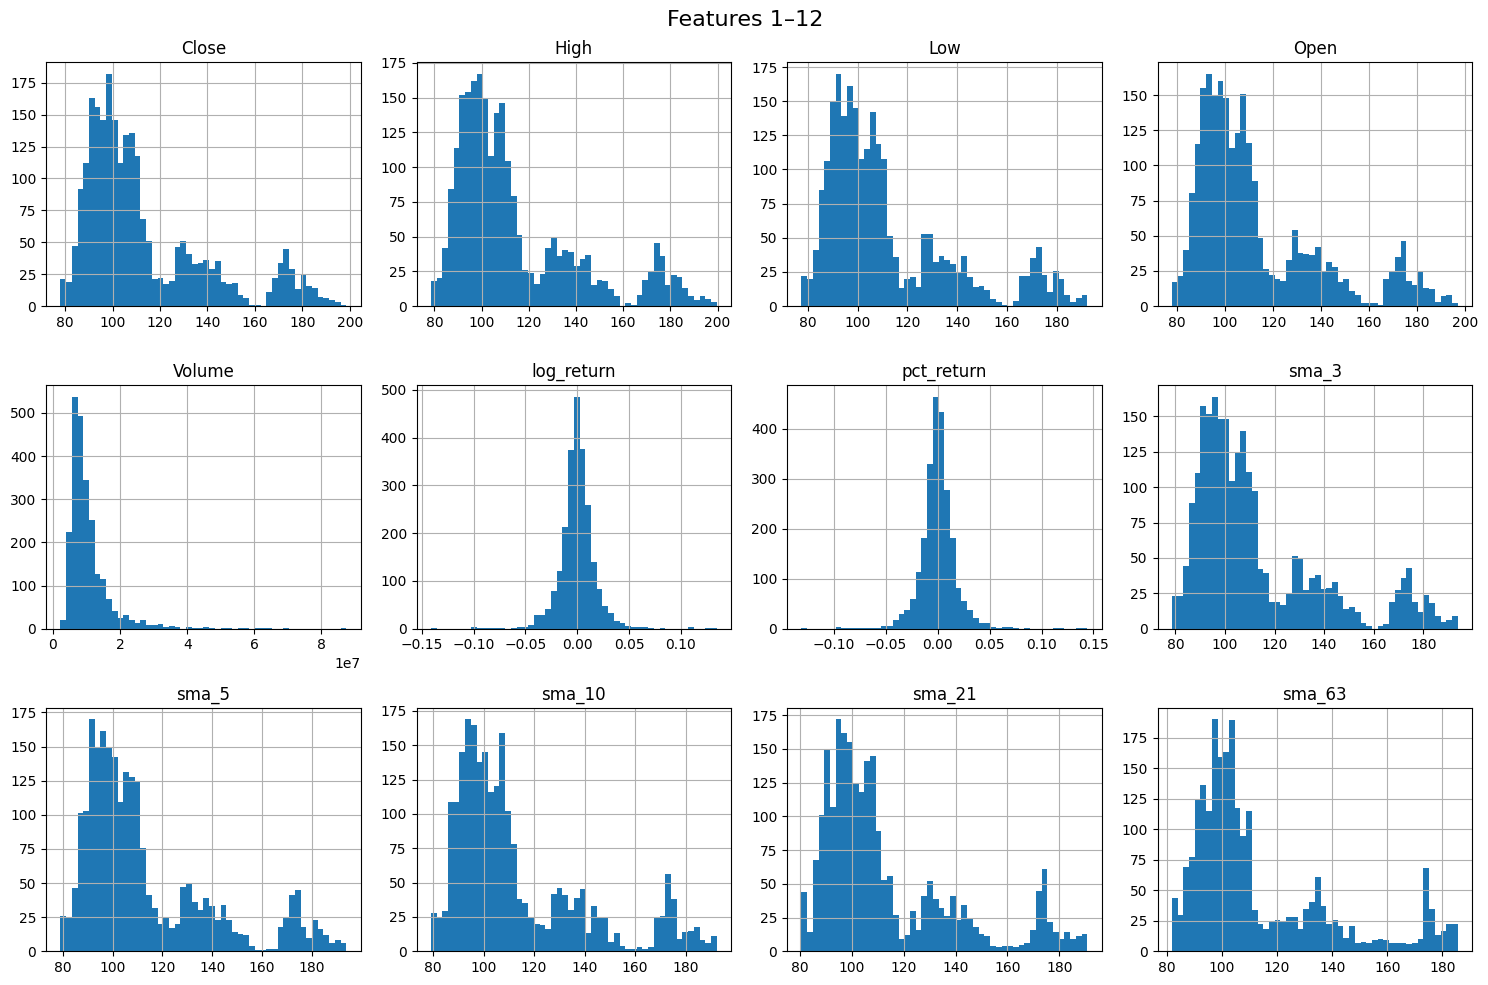

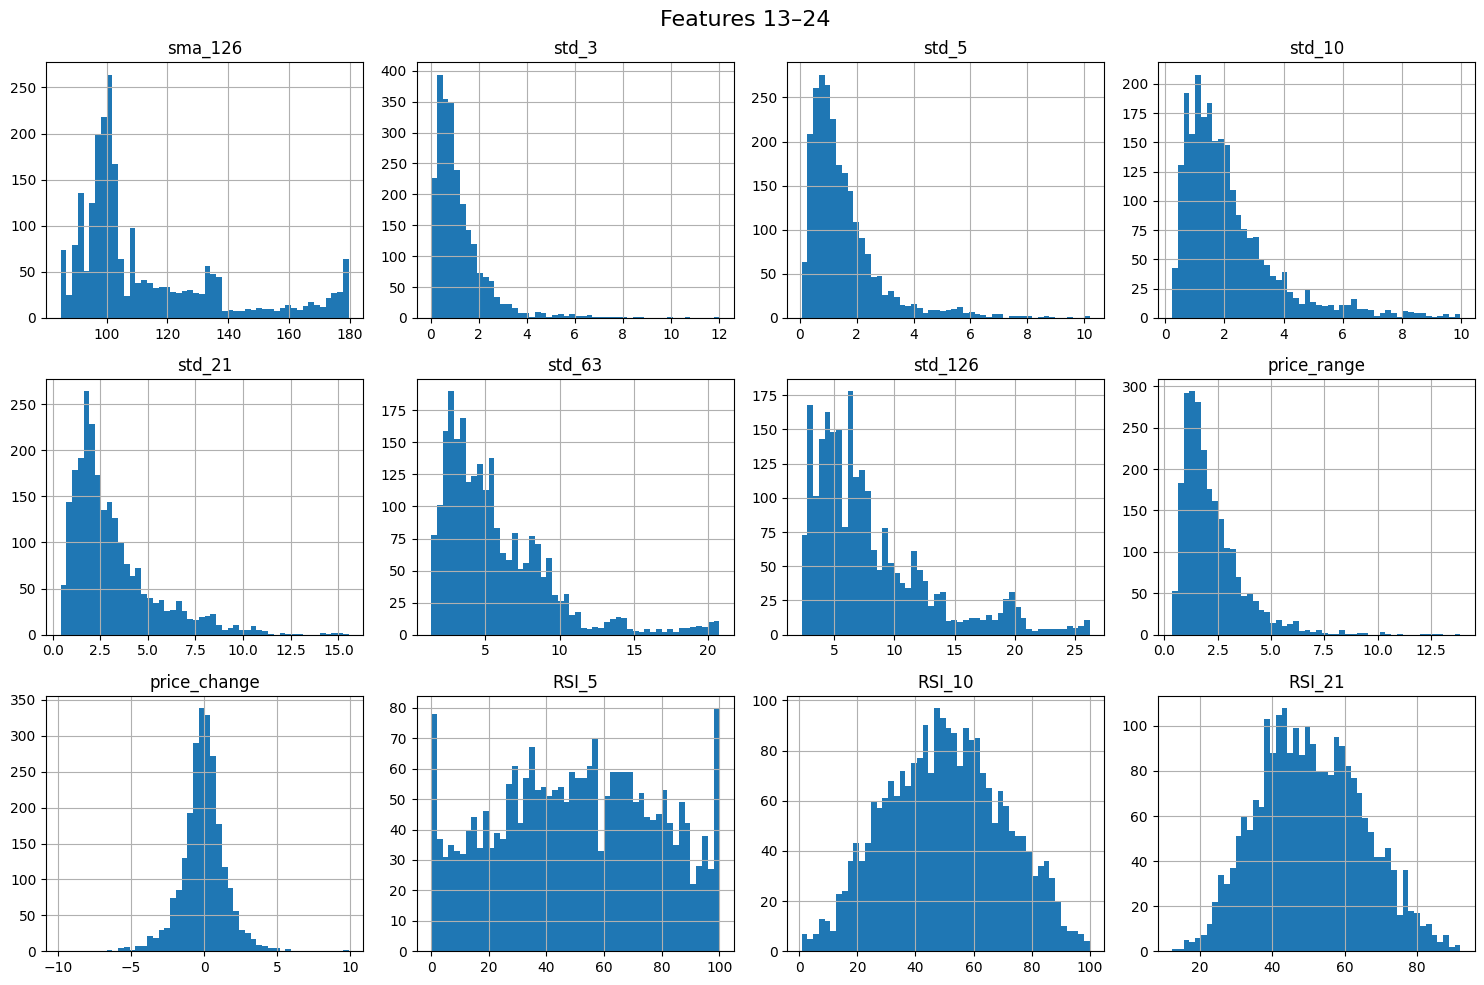

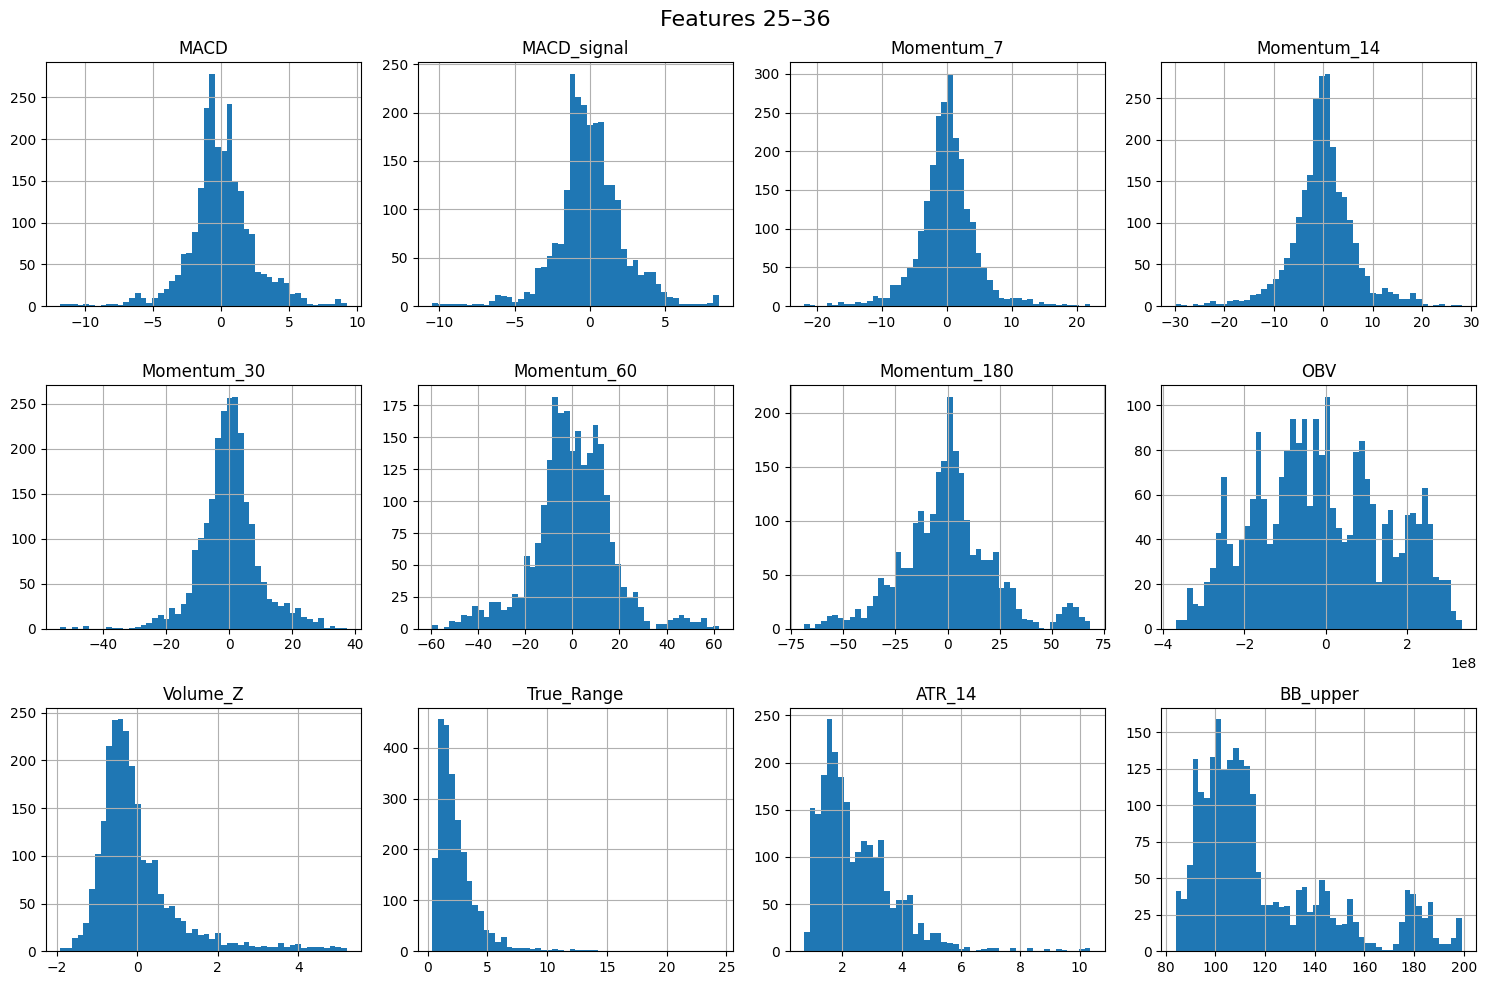

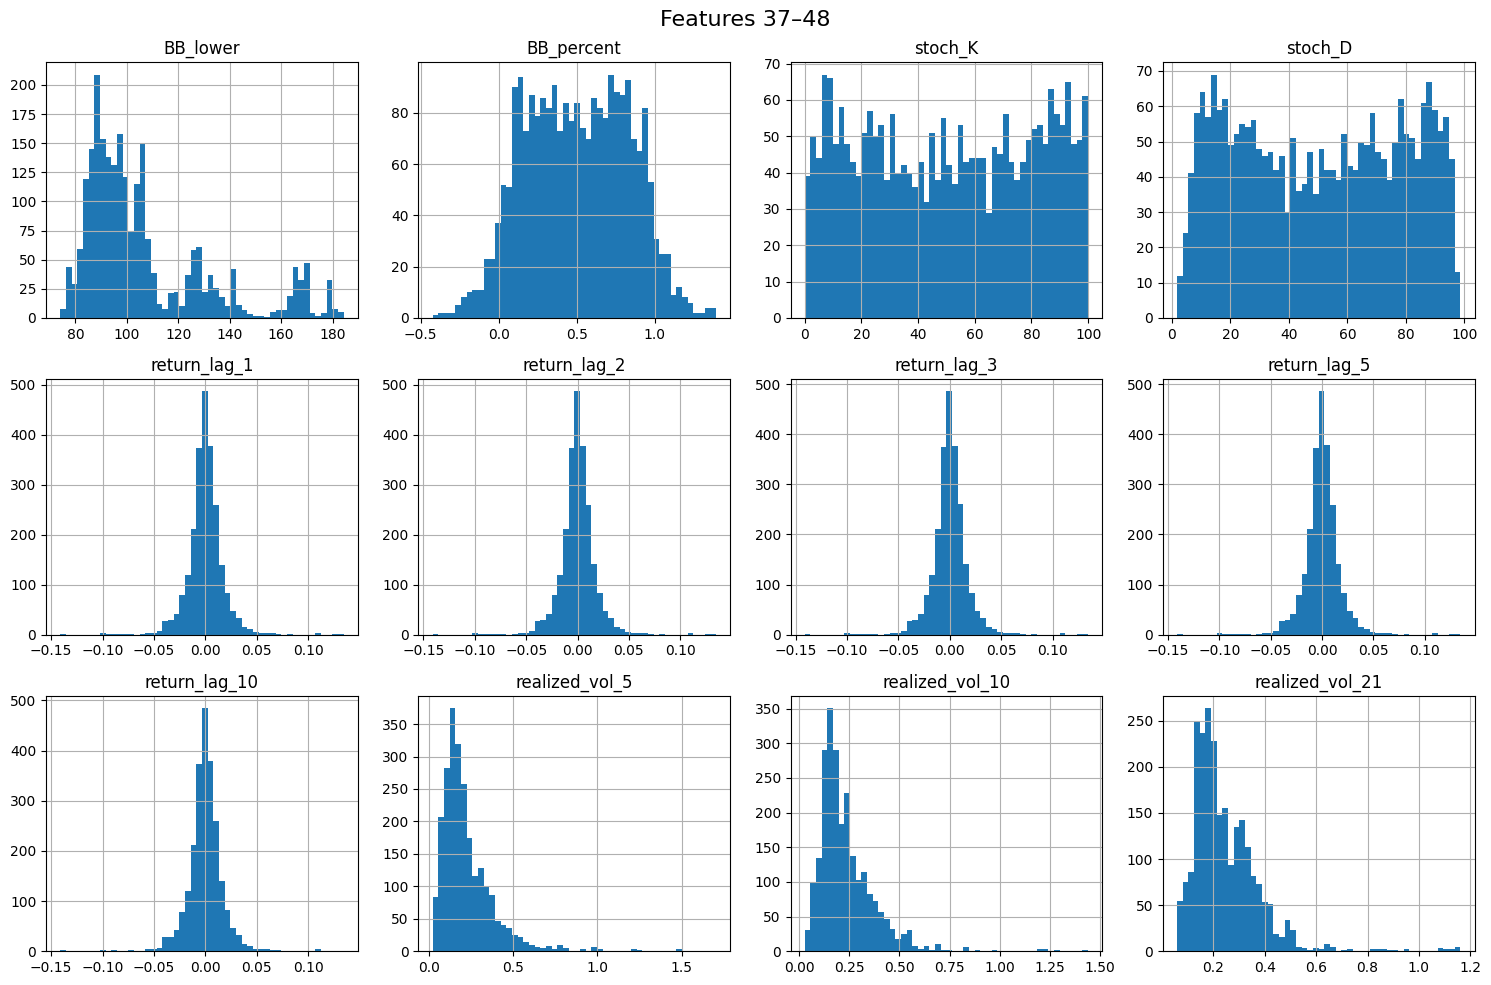

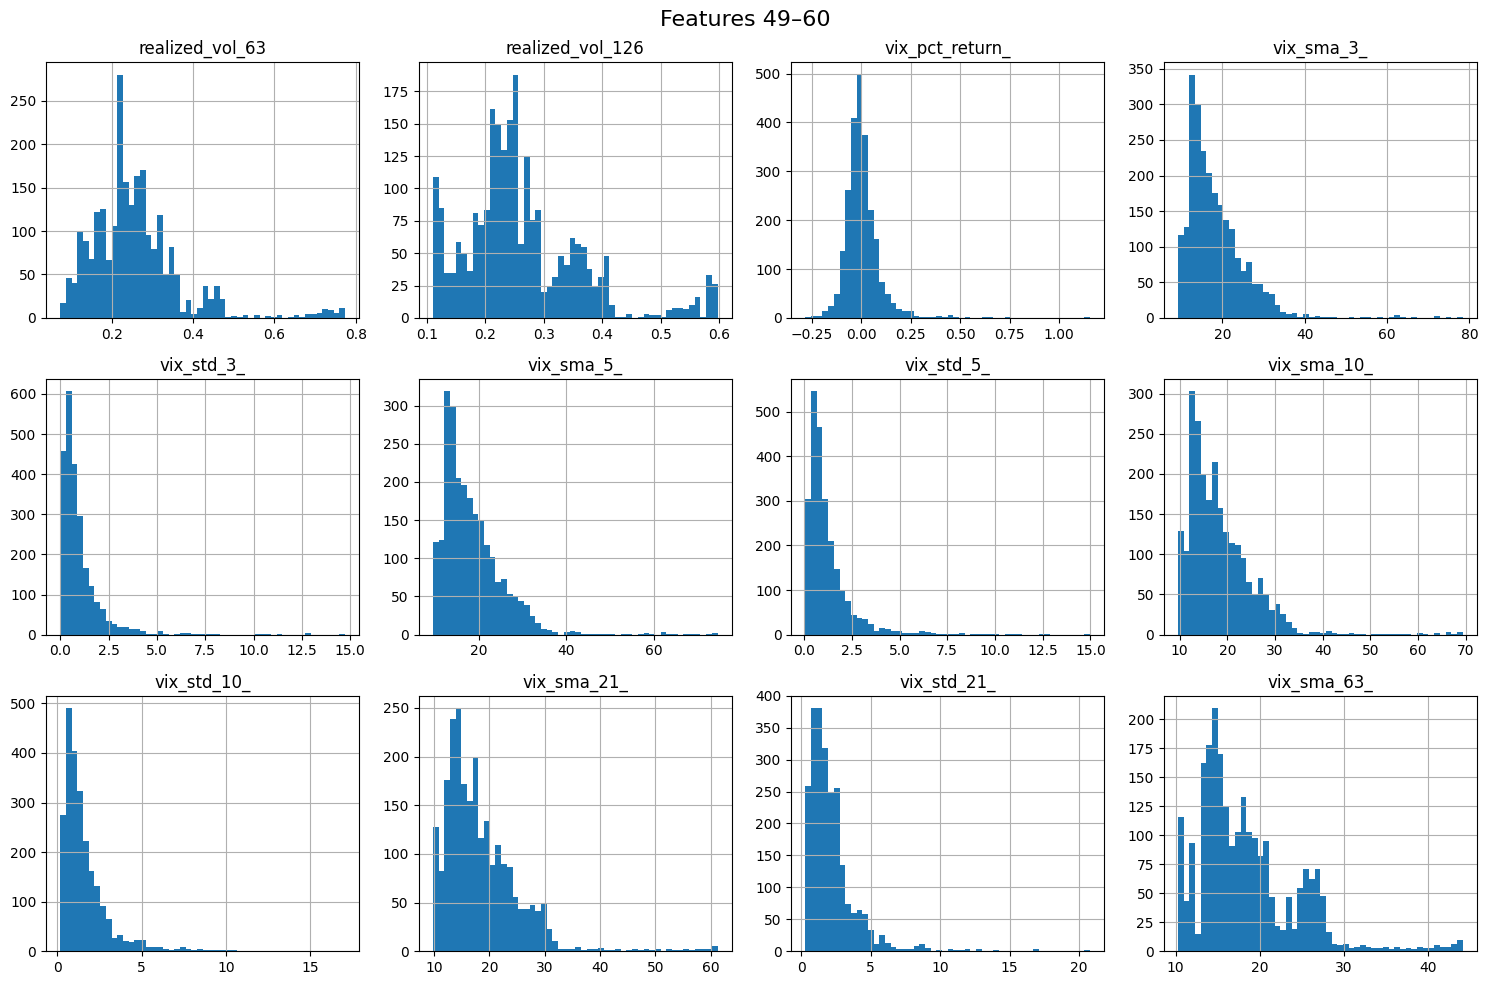

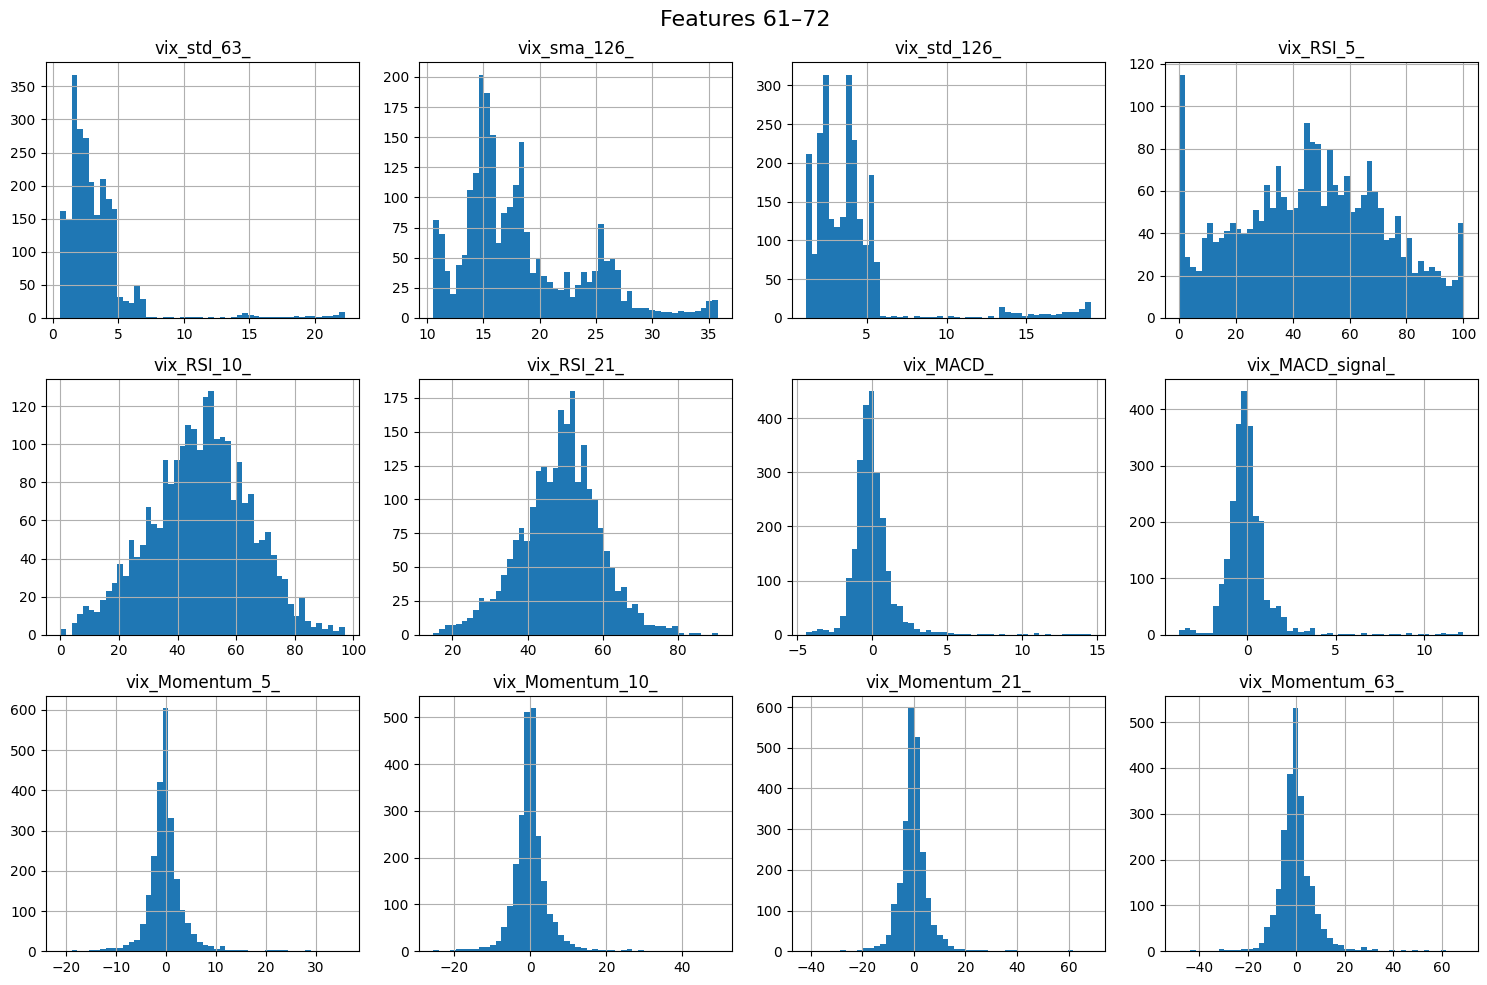

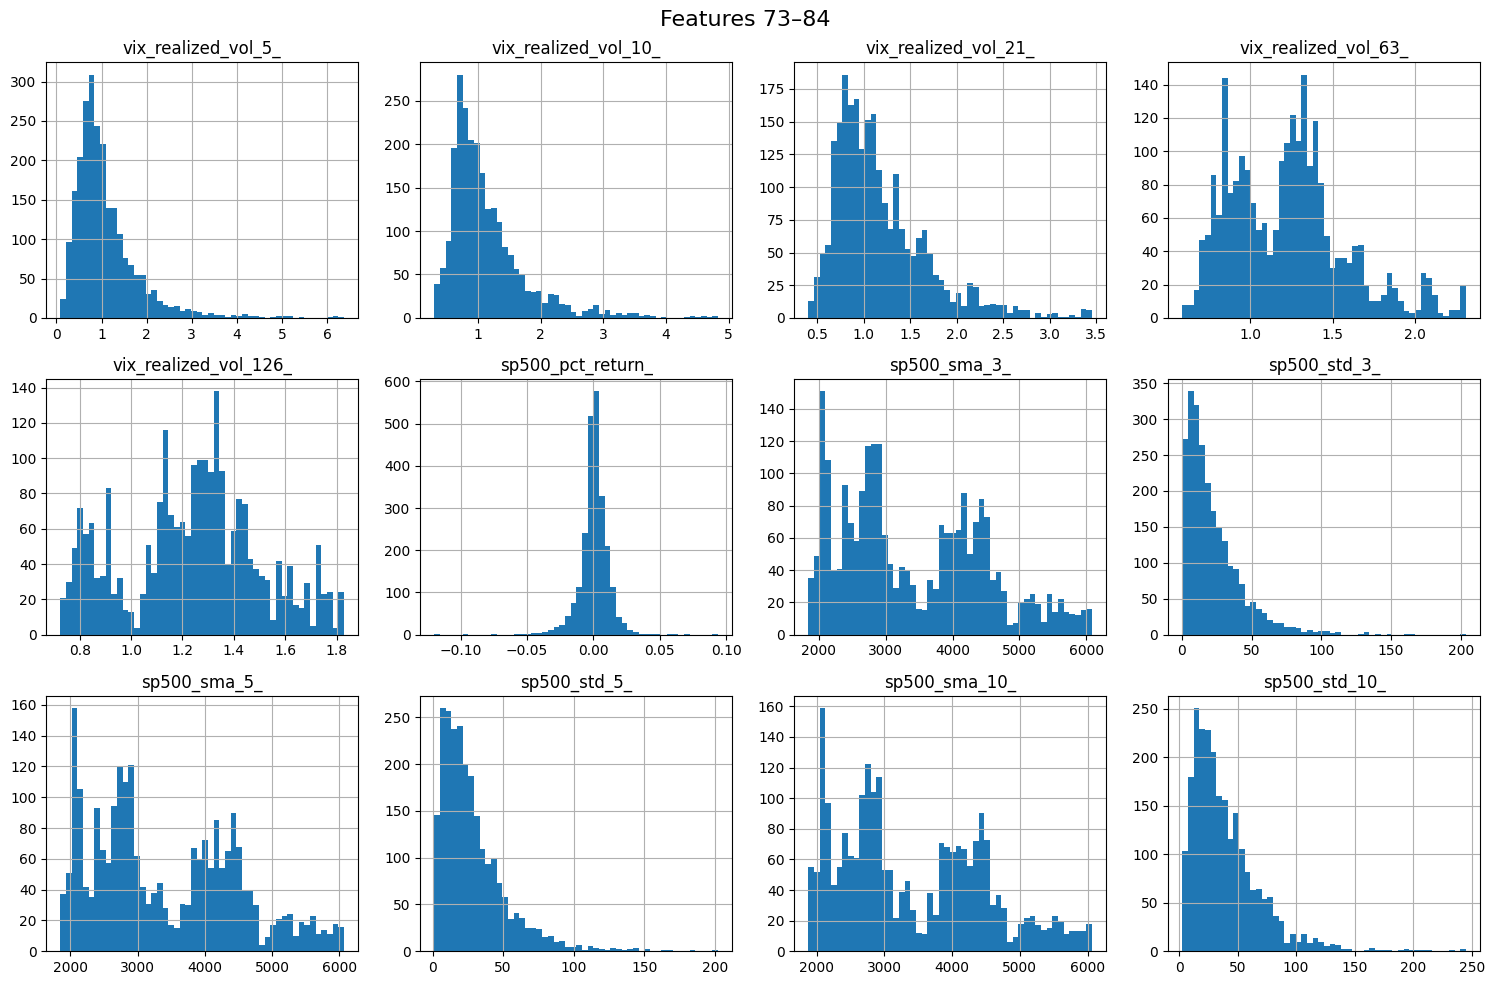

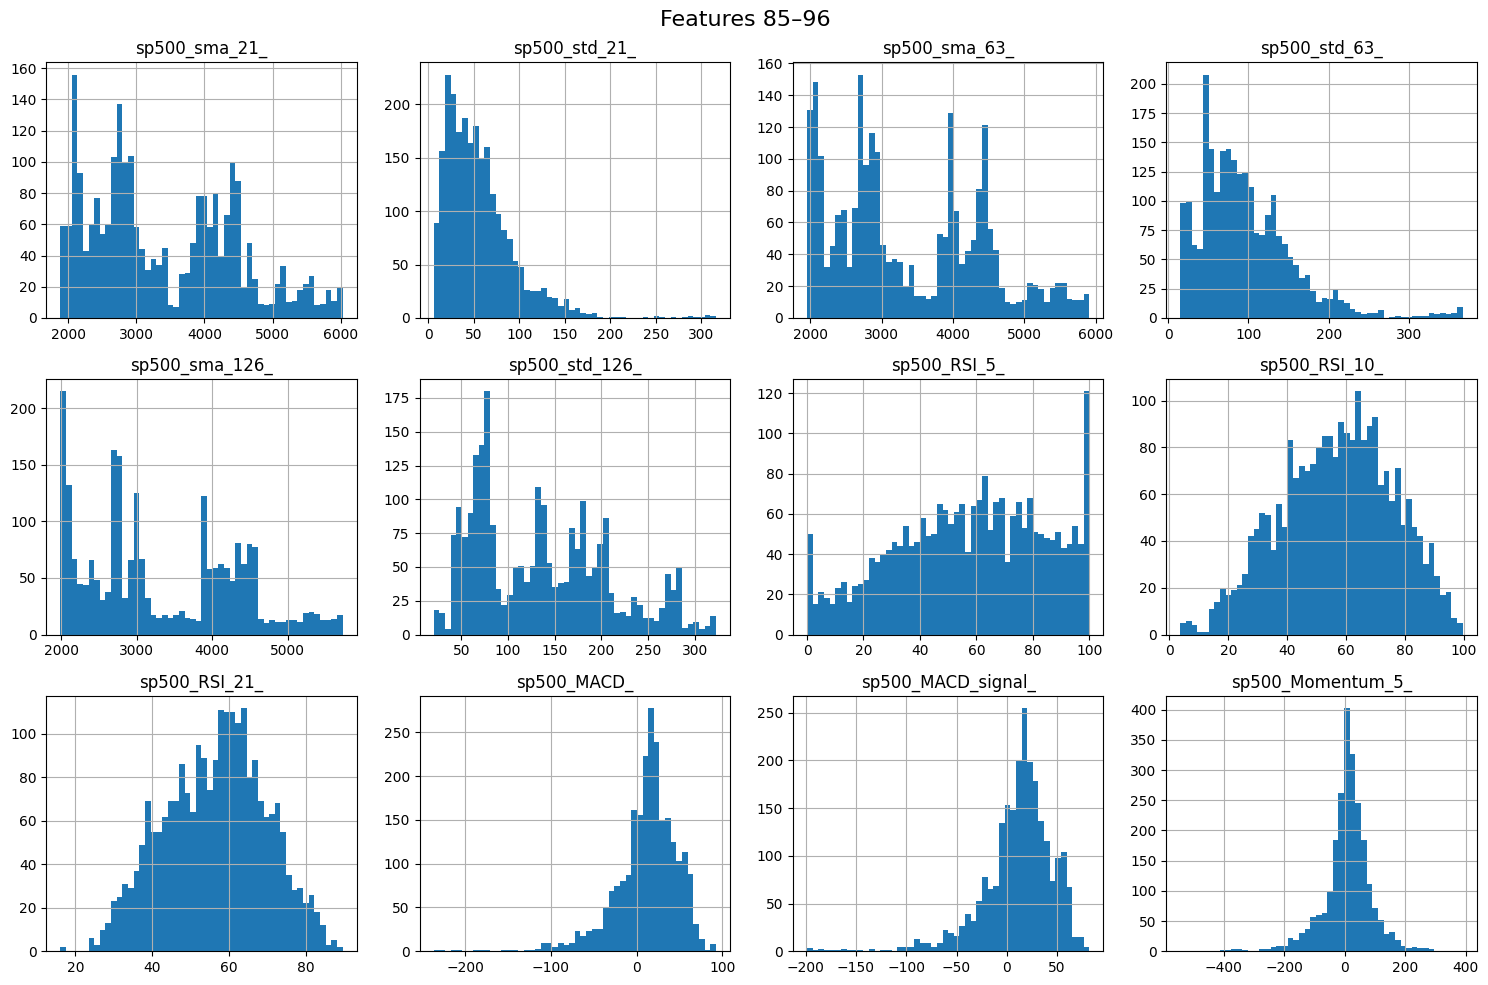

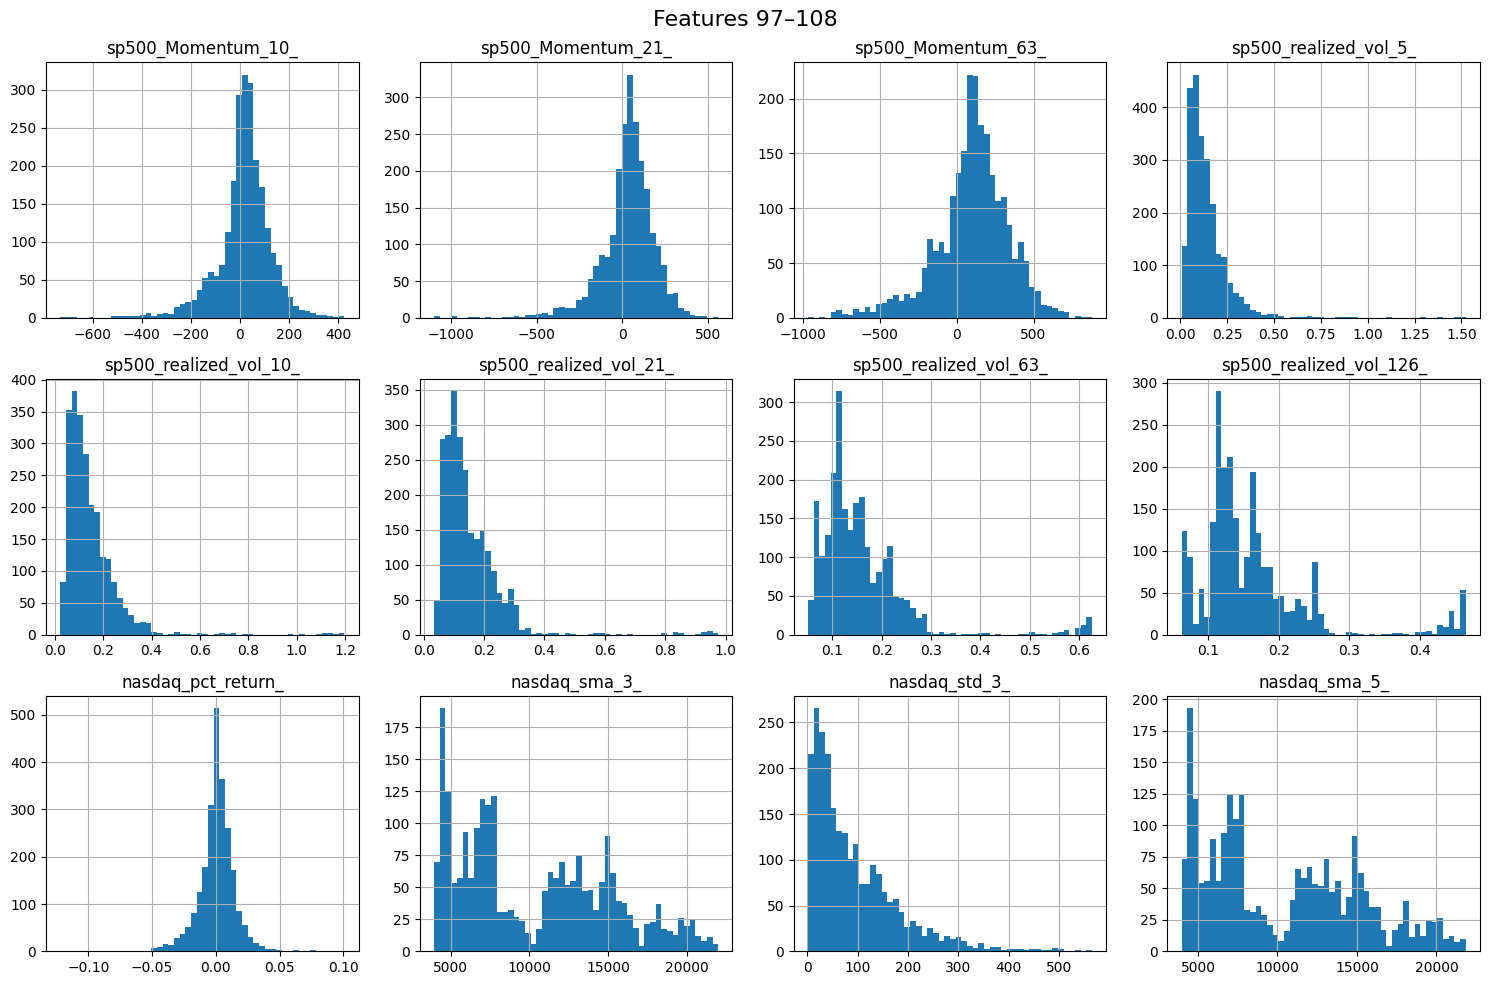

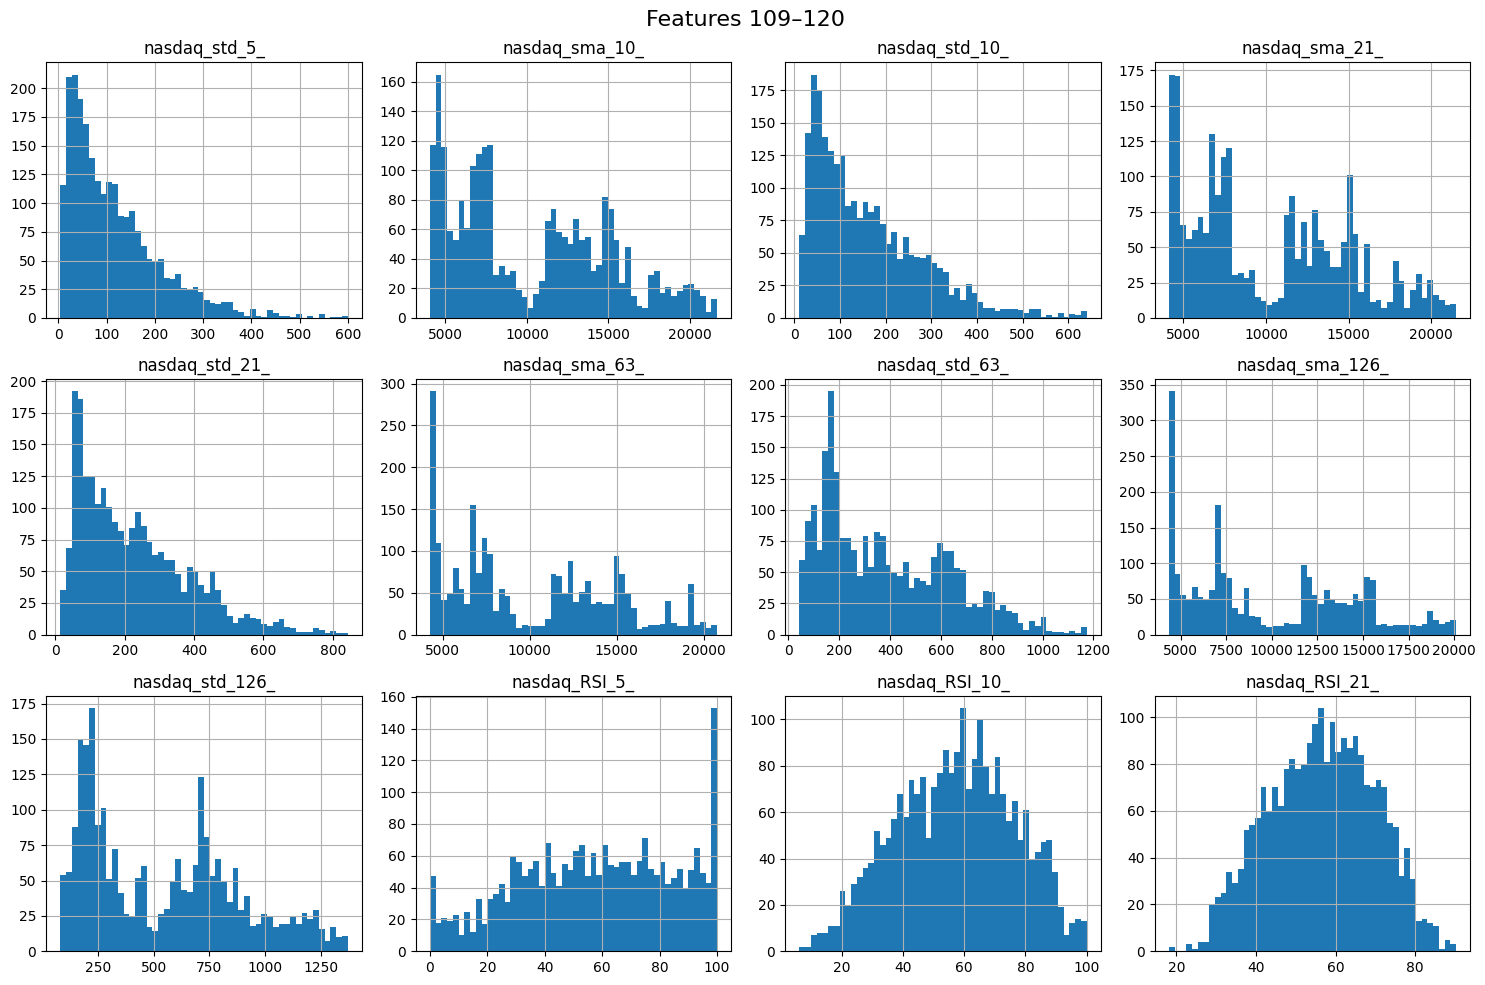

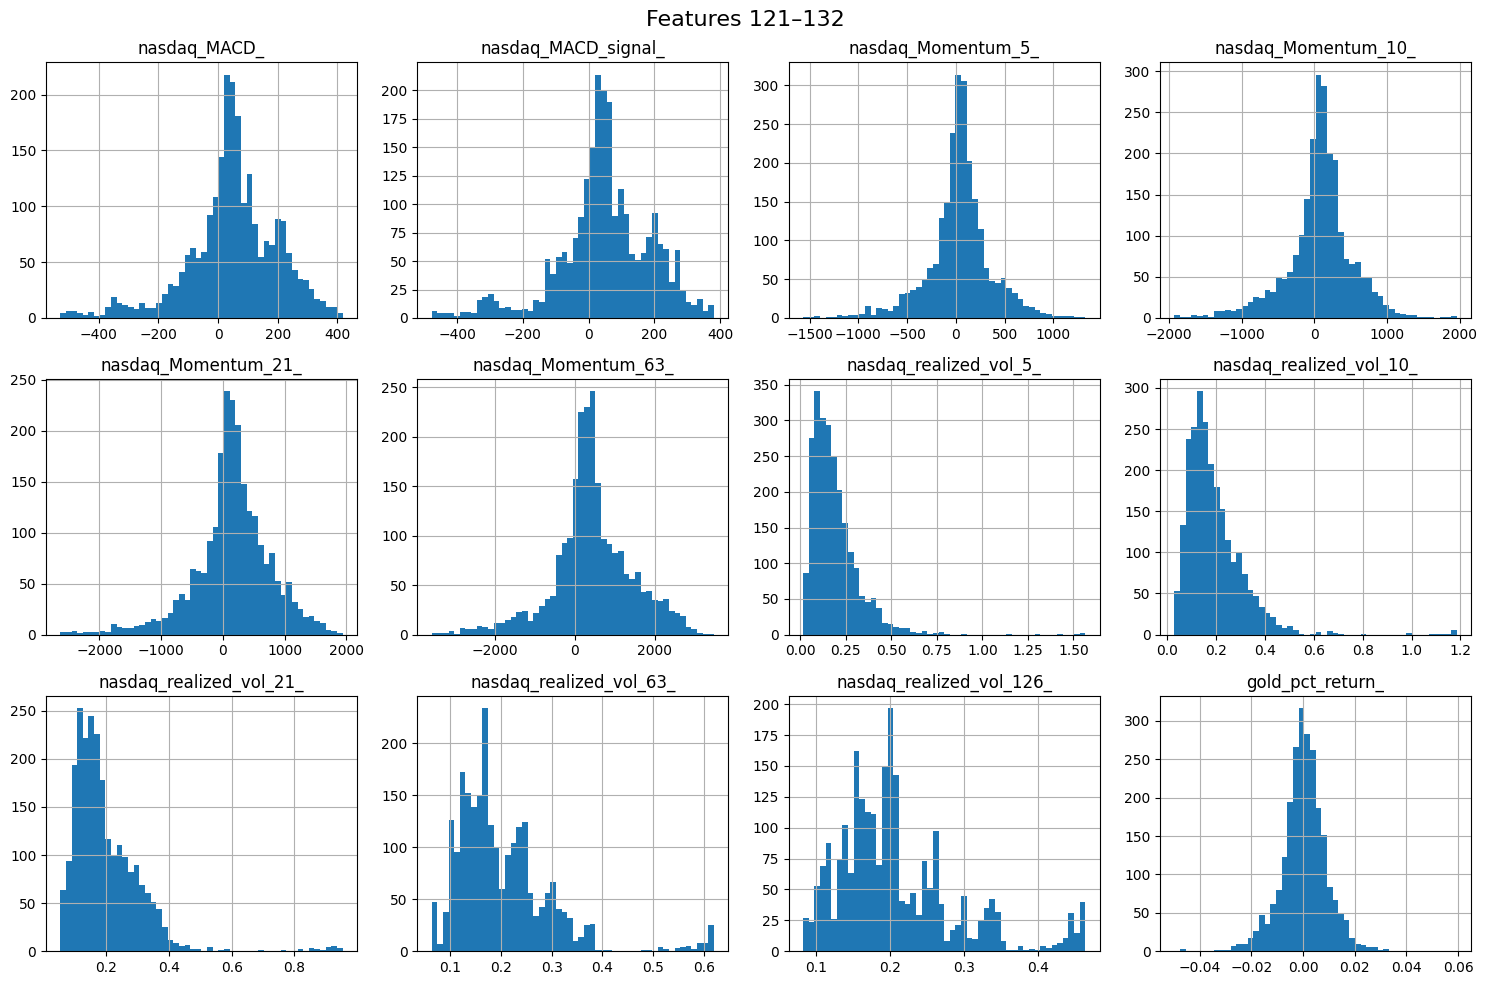

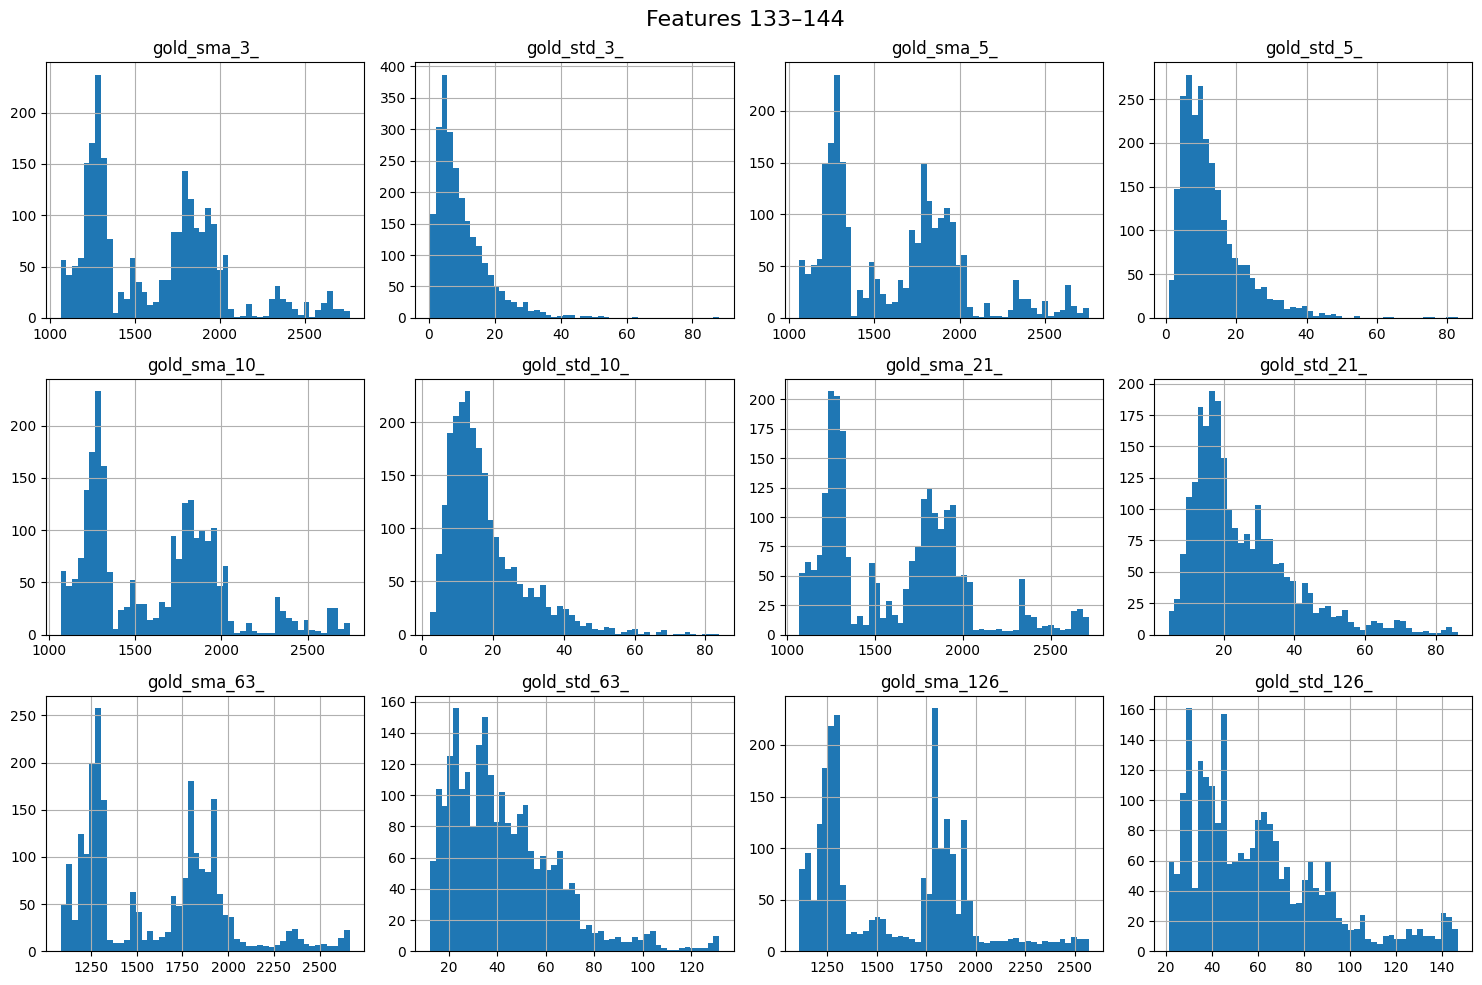

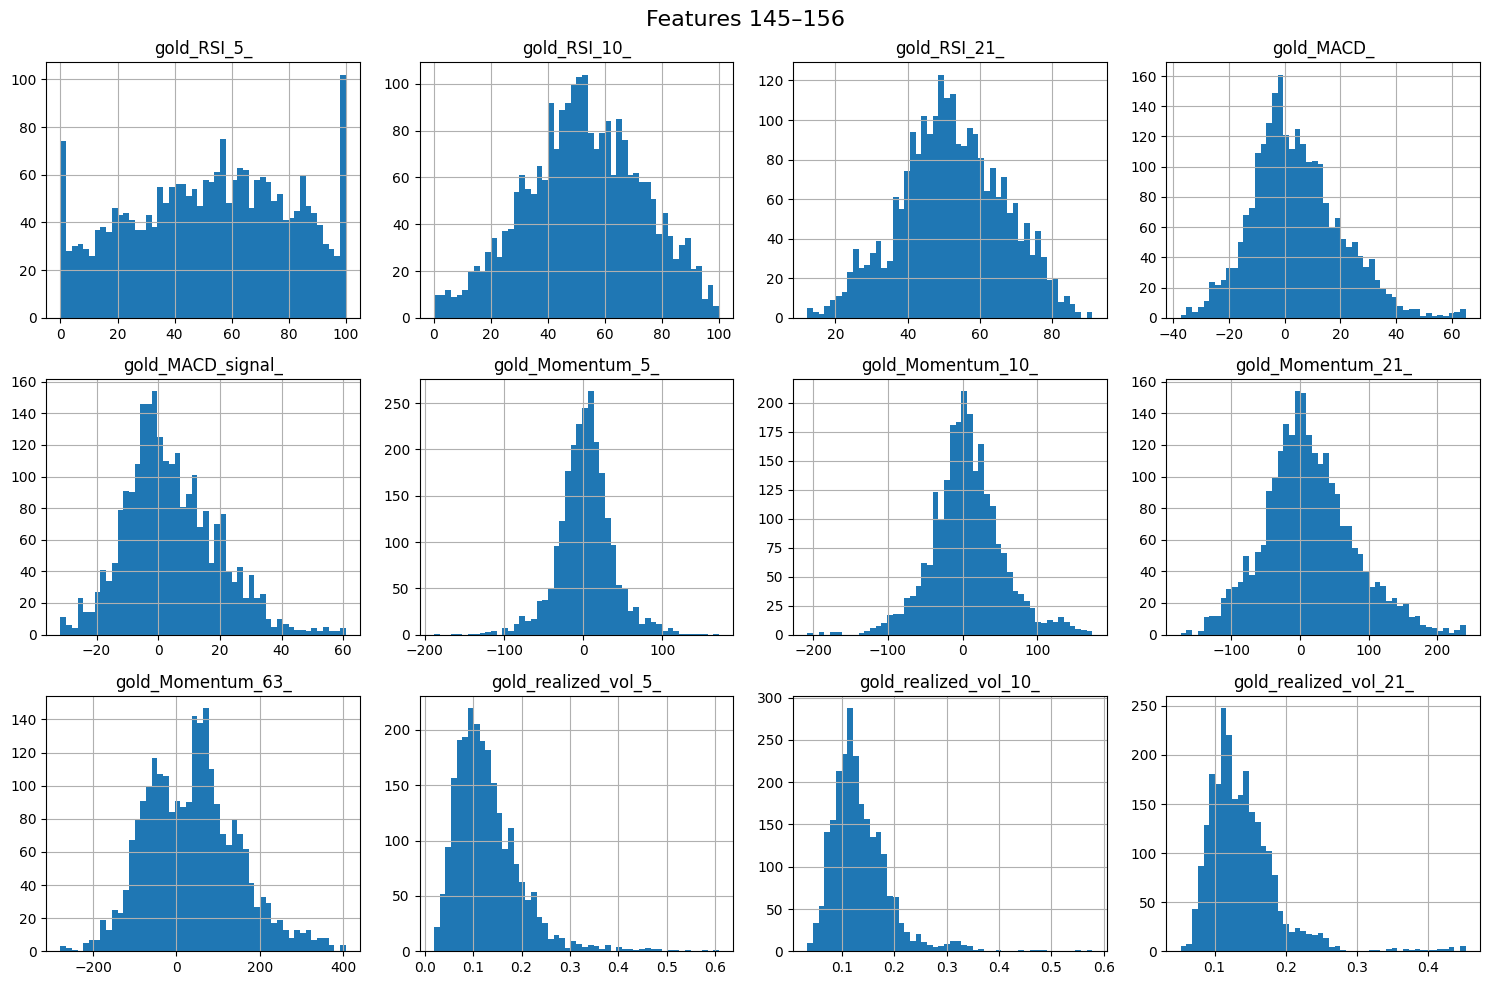

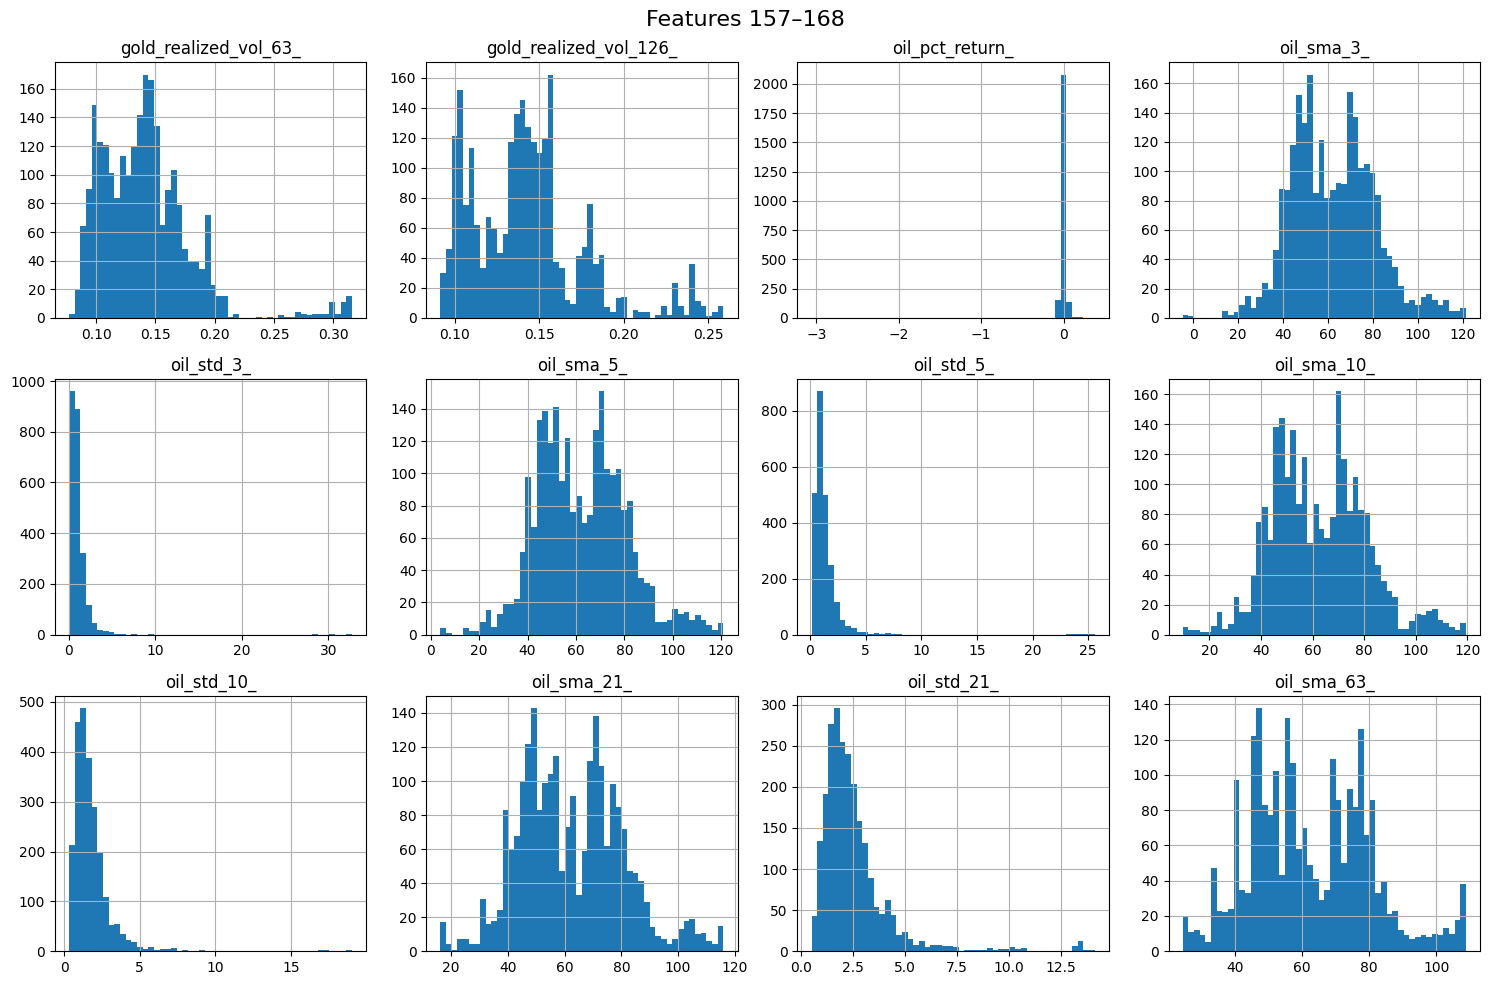

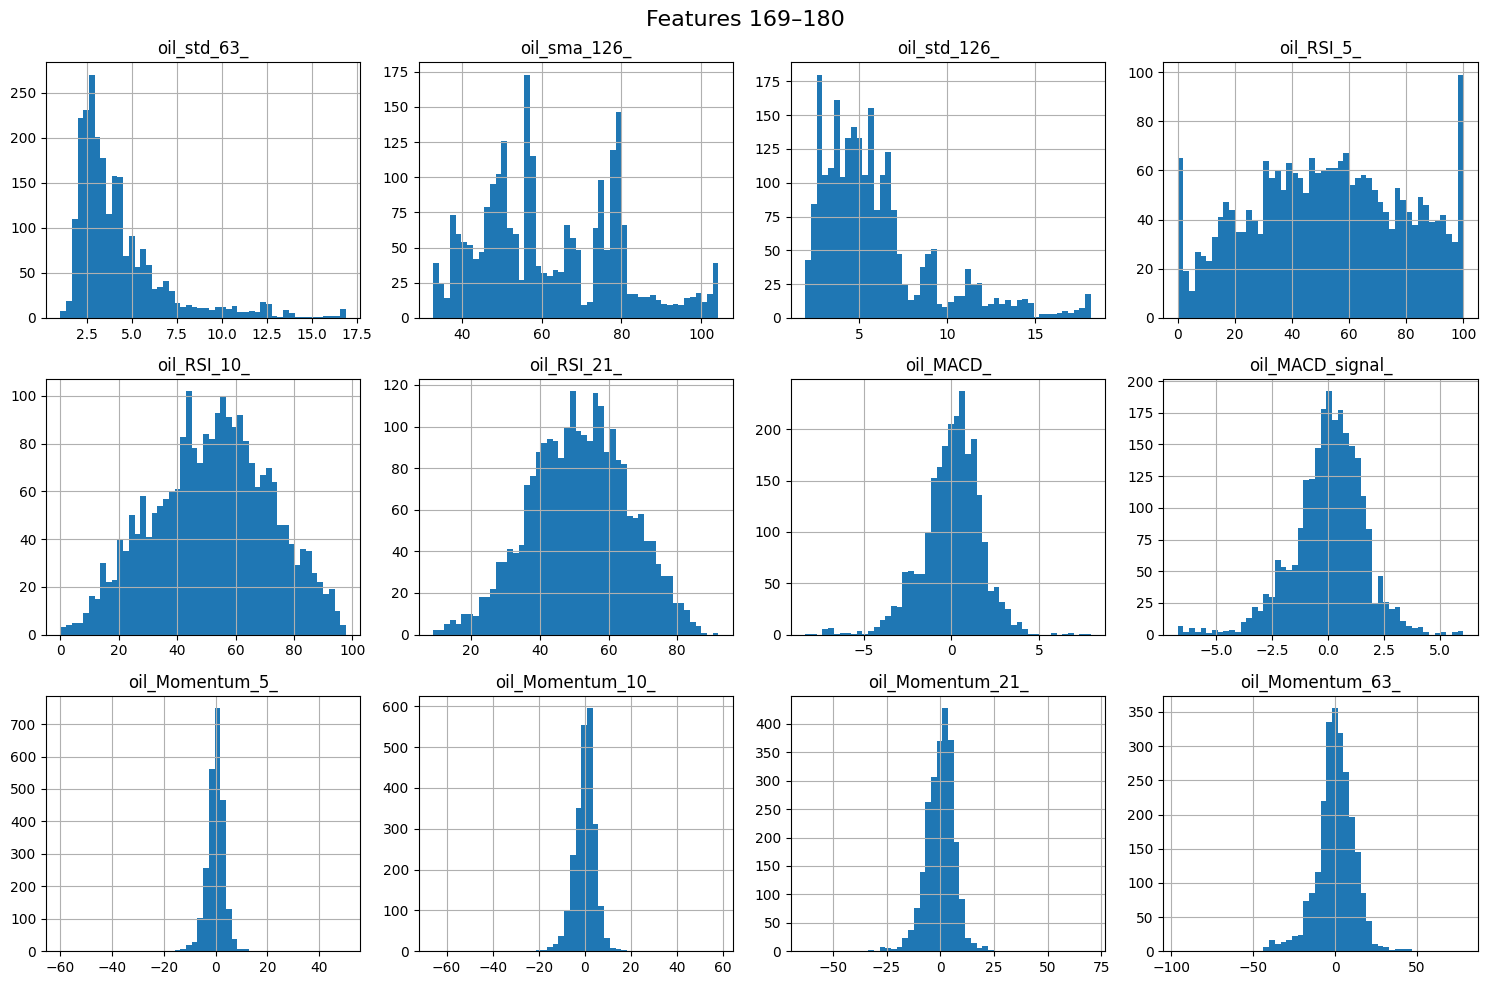

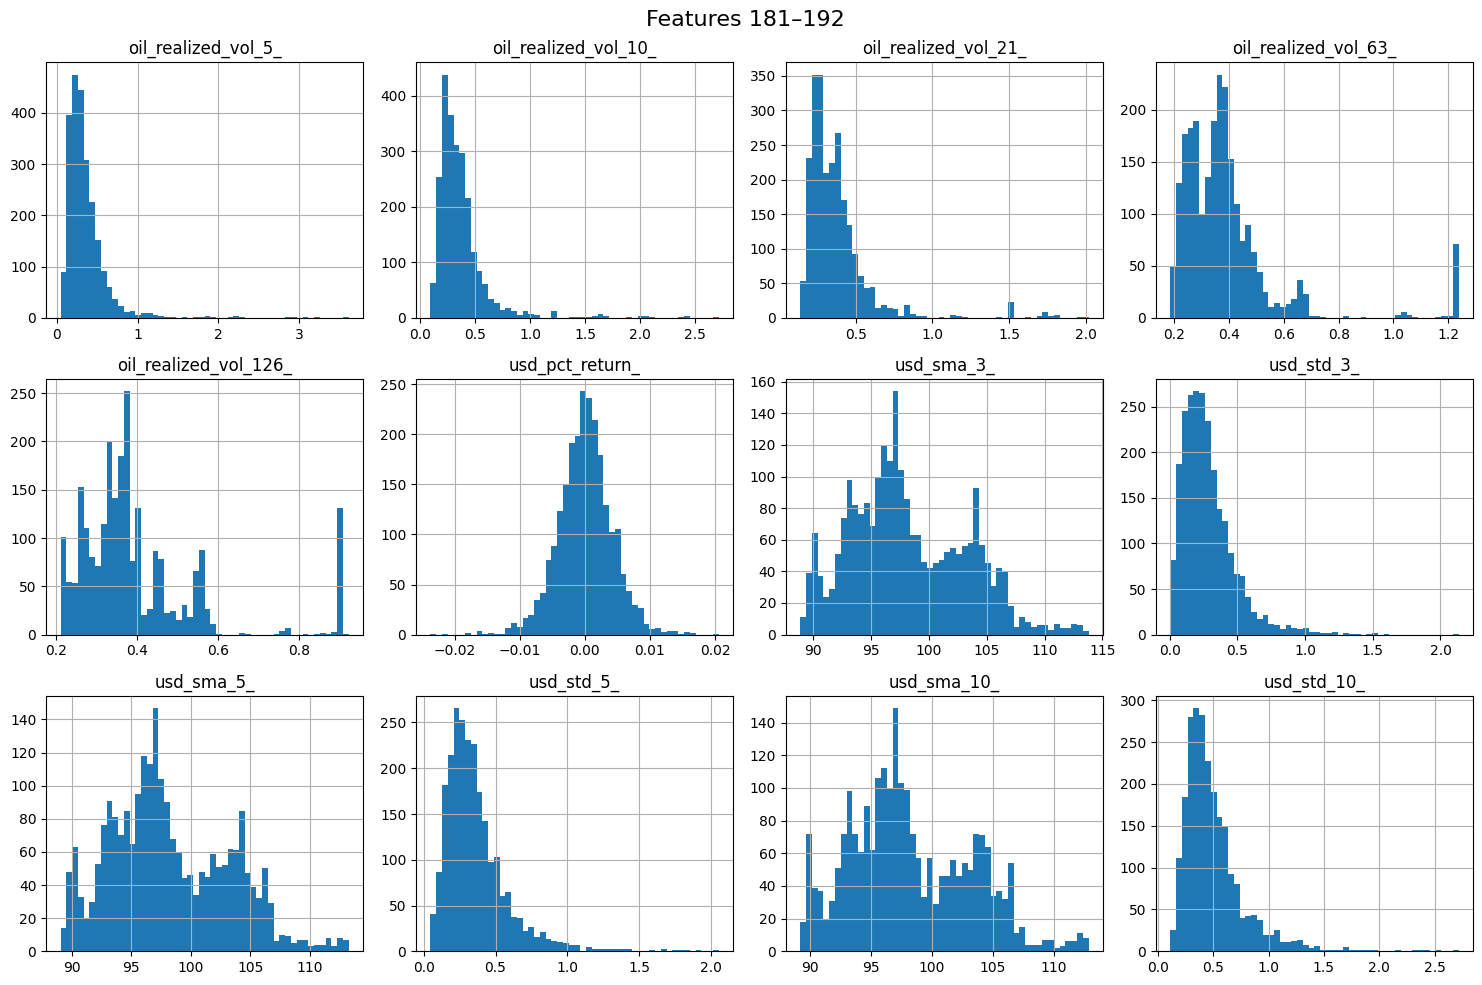

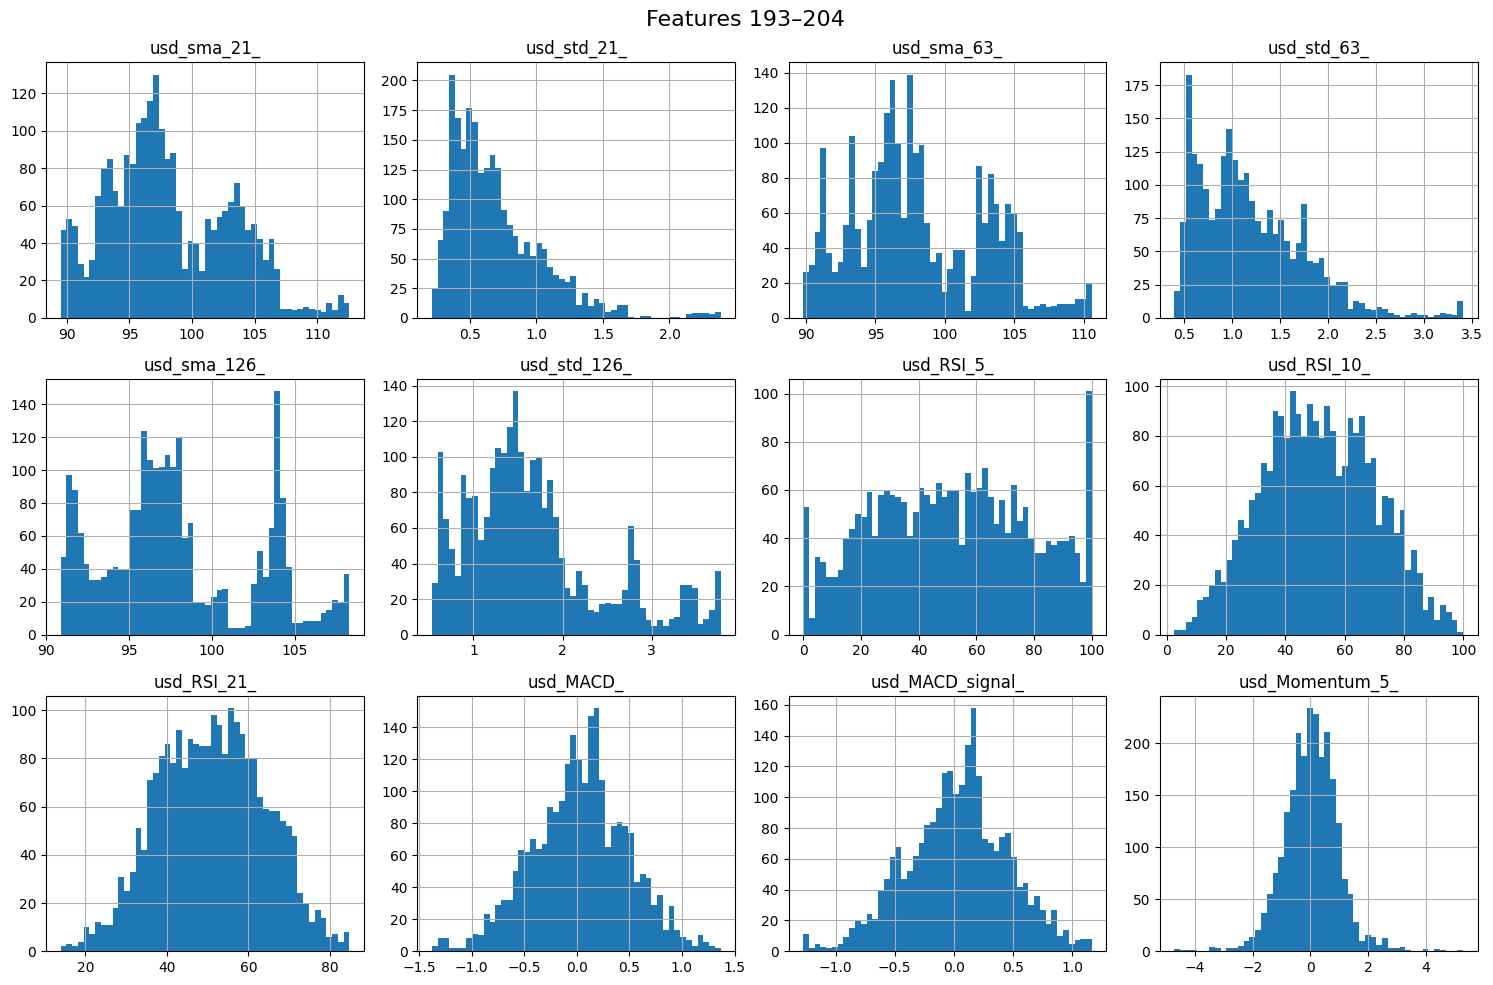

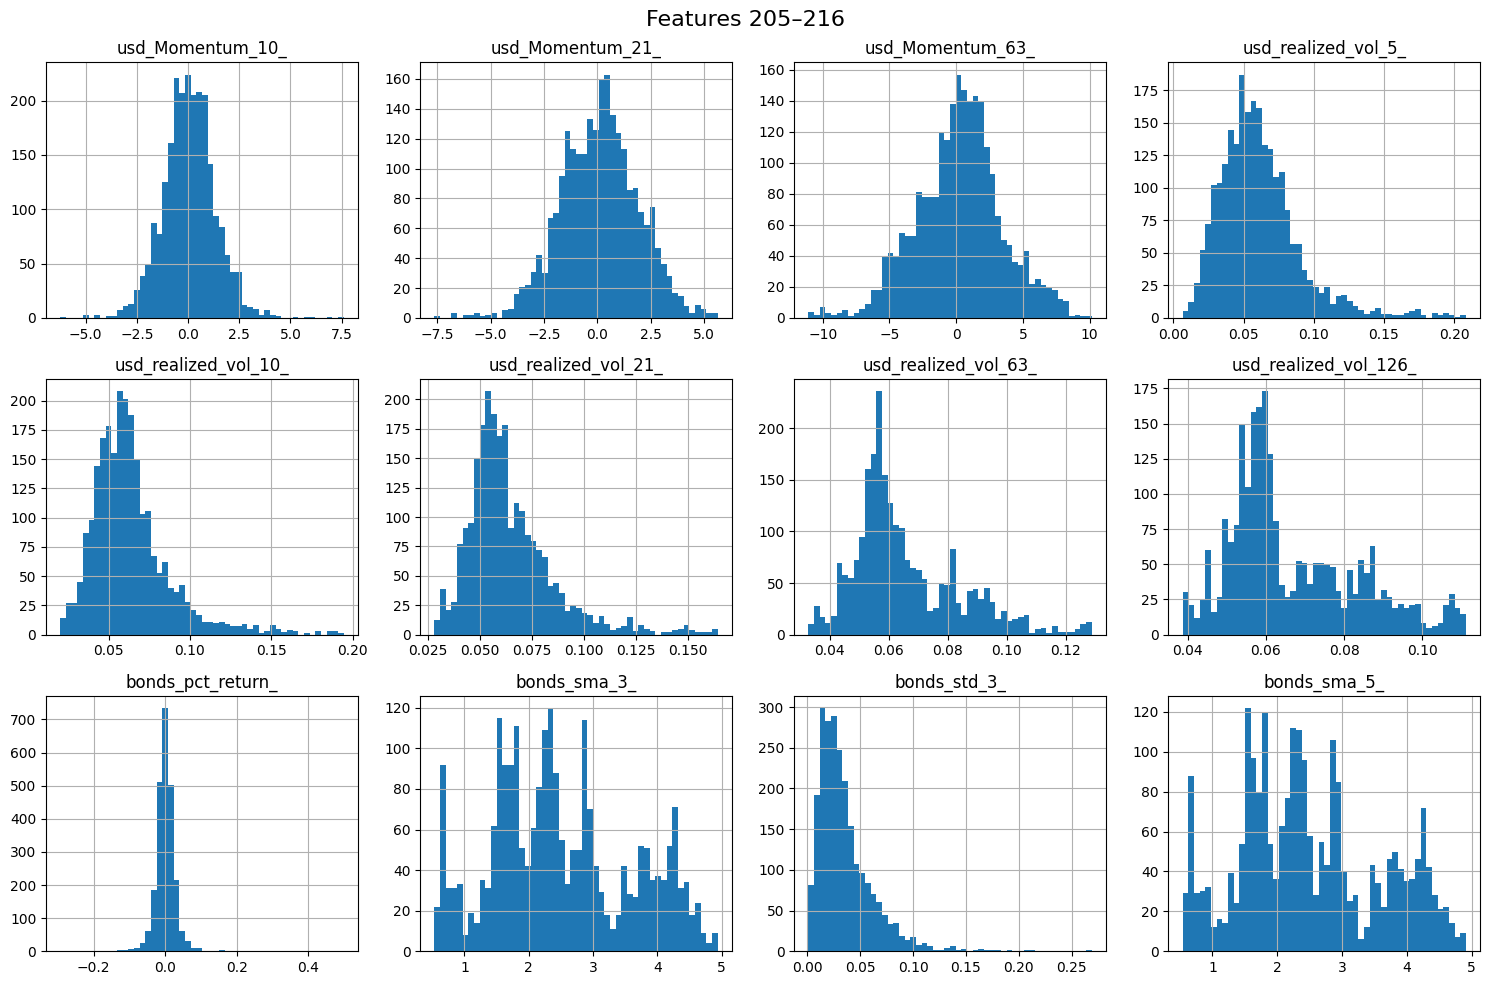

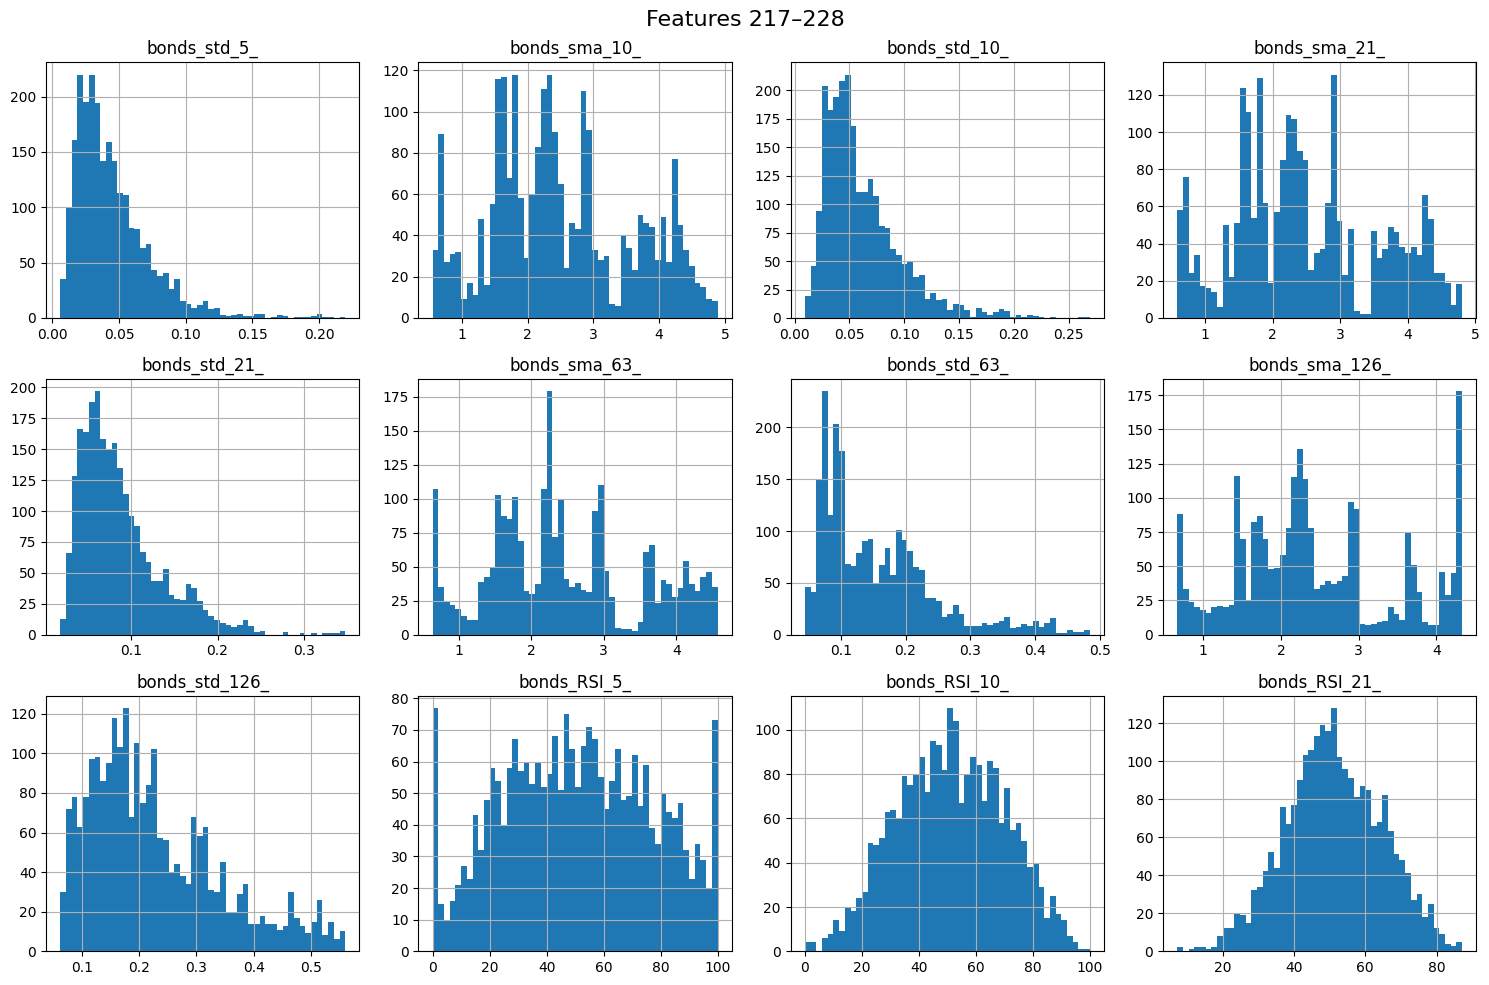

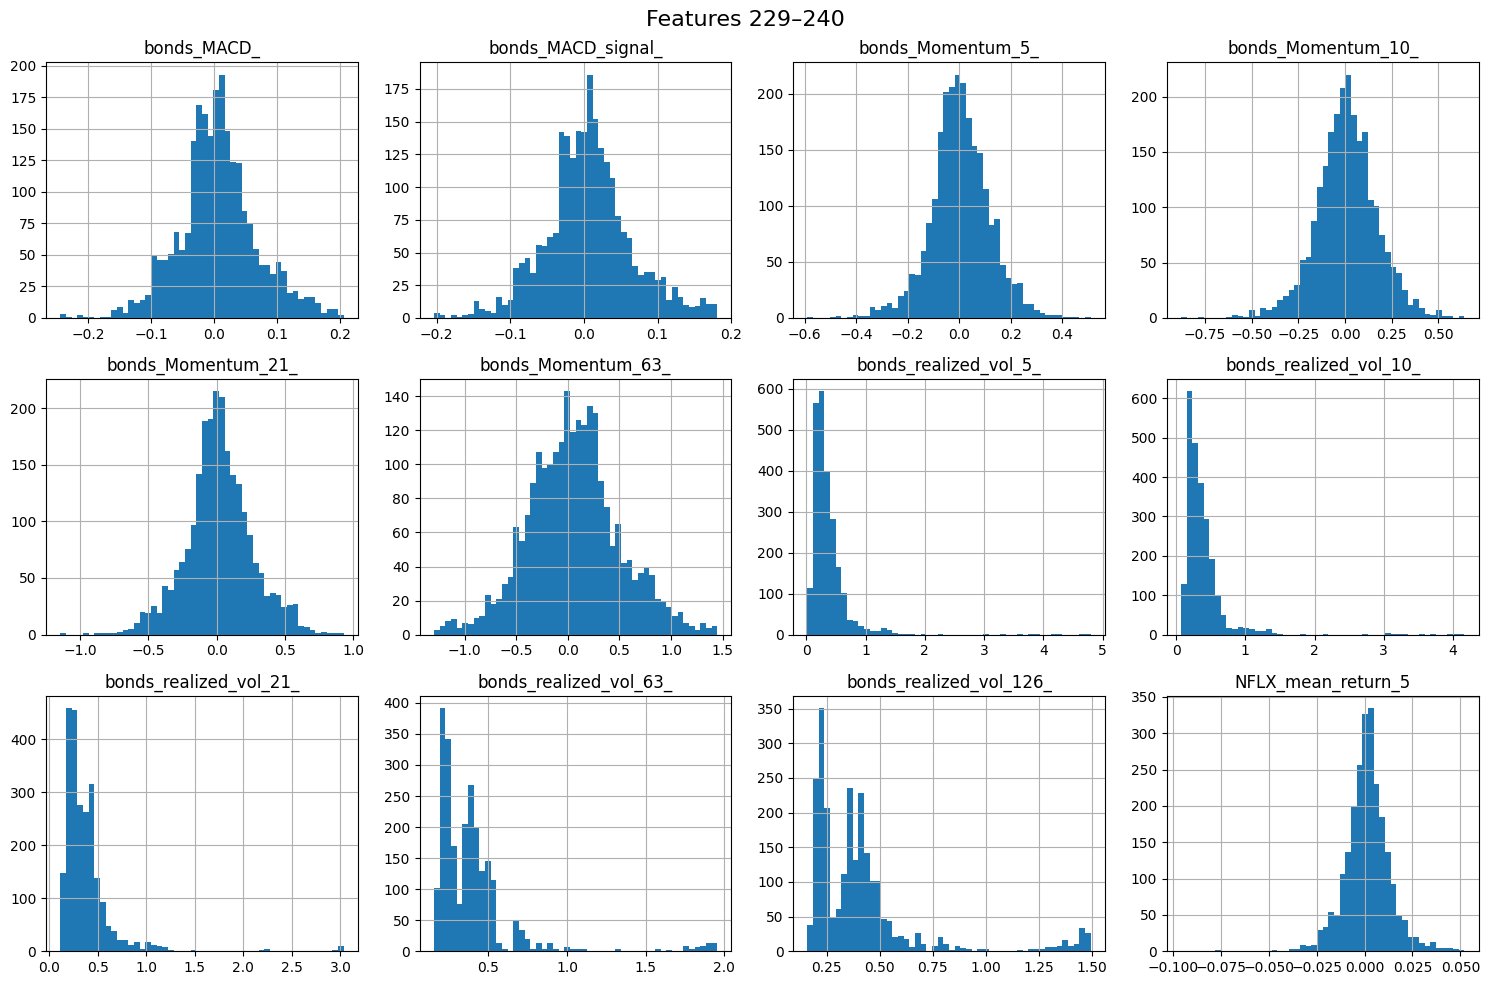

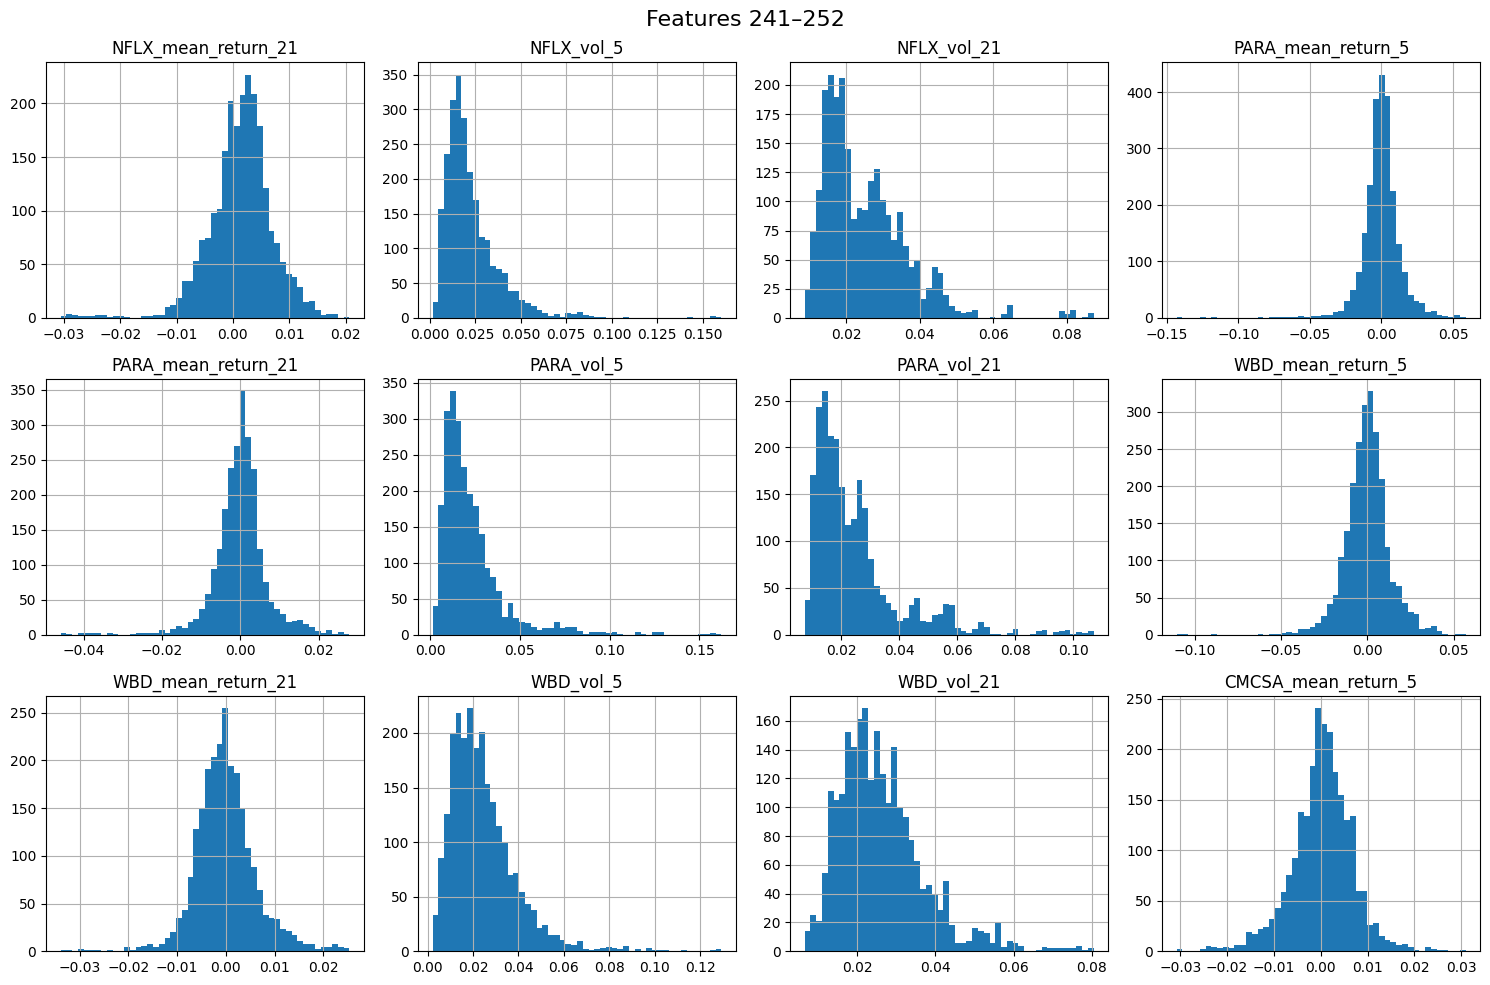

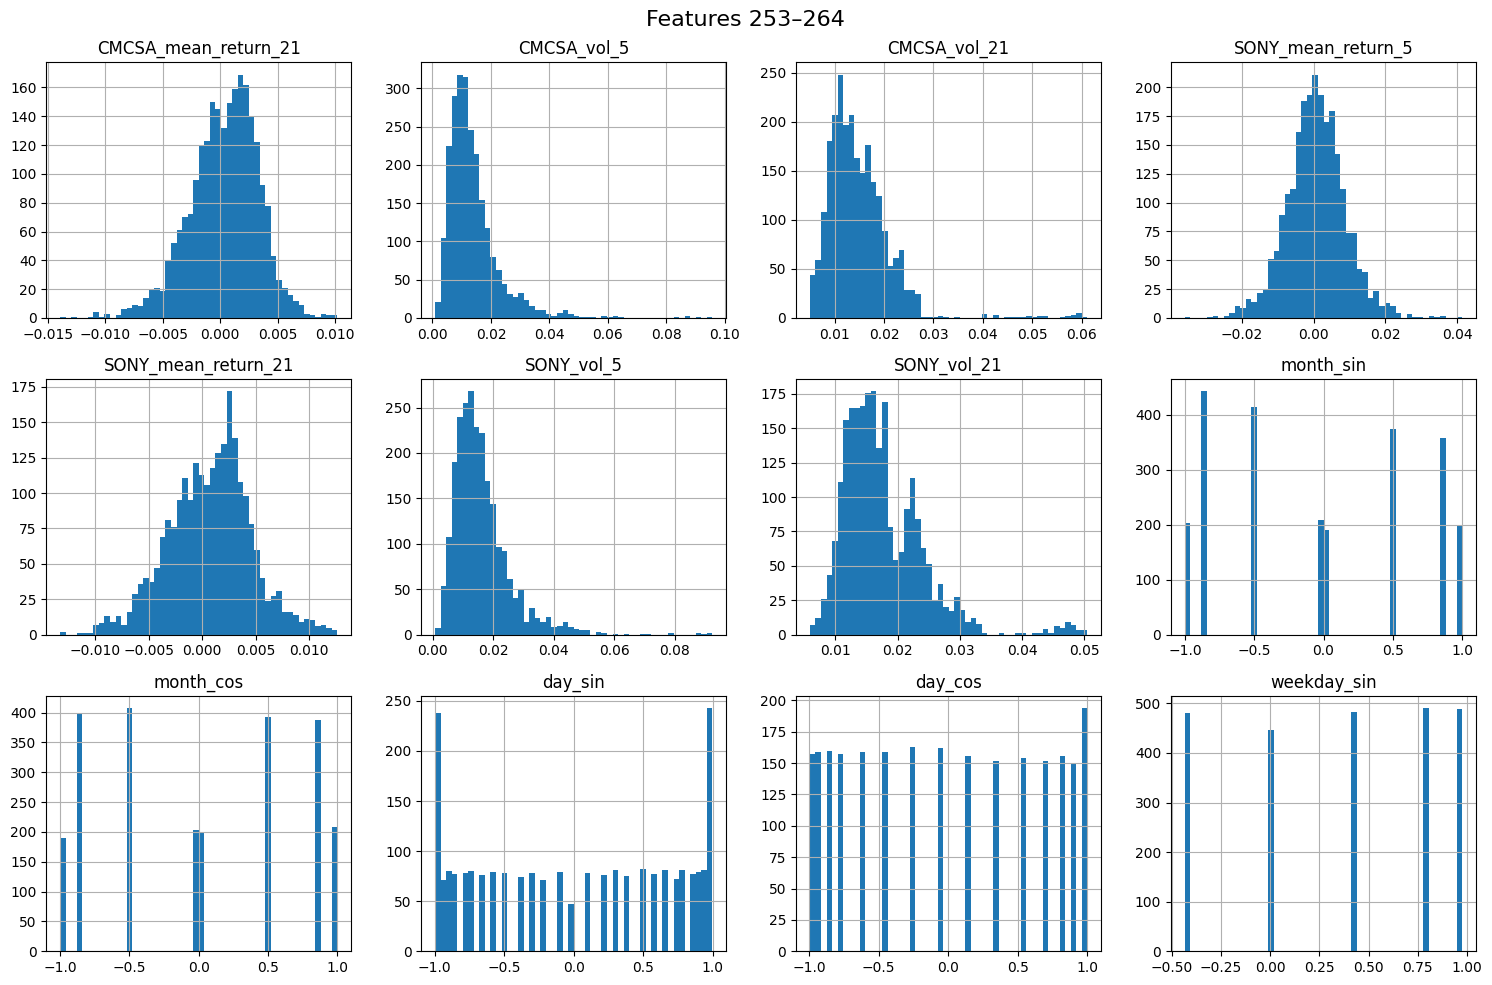

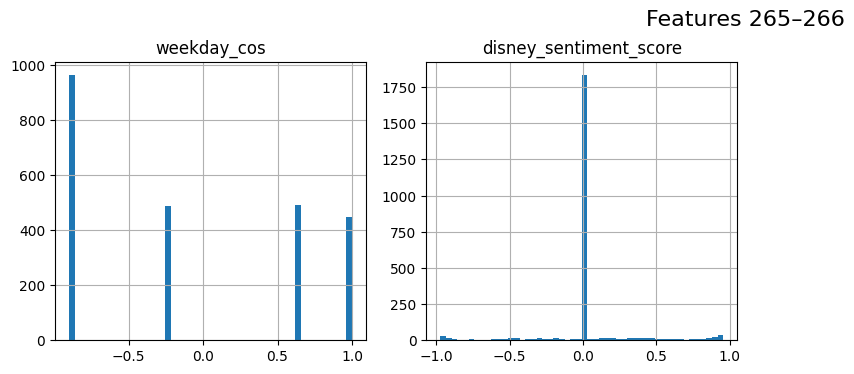

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd 

df_disney_final = pd.read_csv("df_disney_final.csv", index_col = 0).drop(columns='disney_news').dropna(axis=0)

cols = df_disney_final.columns
n_cols = len(cols)
batch_size = 12  # plots per figure

for i in range(0, n_cols, batch_size):
    subset = cols[i:i+batch_size]
    df_disney_final[subset].hist(bins=50, figsize=(15, 10), layout=(3, 4))
    plt.suptitle(f"Features {i+1}–{min(i+batch_size, n_cols)}", fontsize=16)
    plt.tight_layout()
    plt.show()


/home/kristijonas/.pyenv/versions/stock_transformers_env/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/kristijonas/.pyenv/versions/stock_transformers_env/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


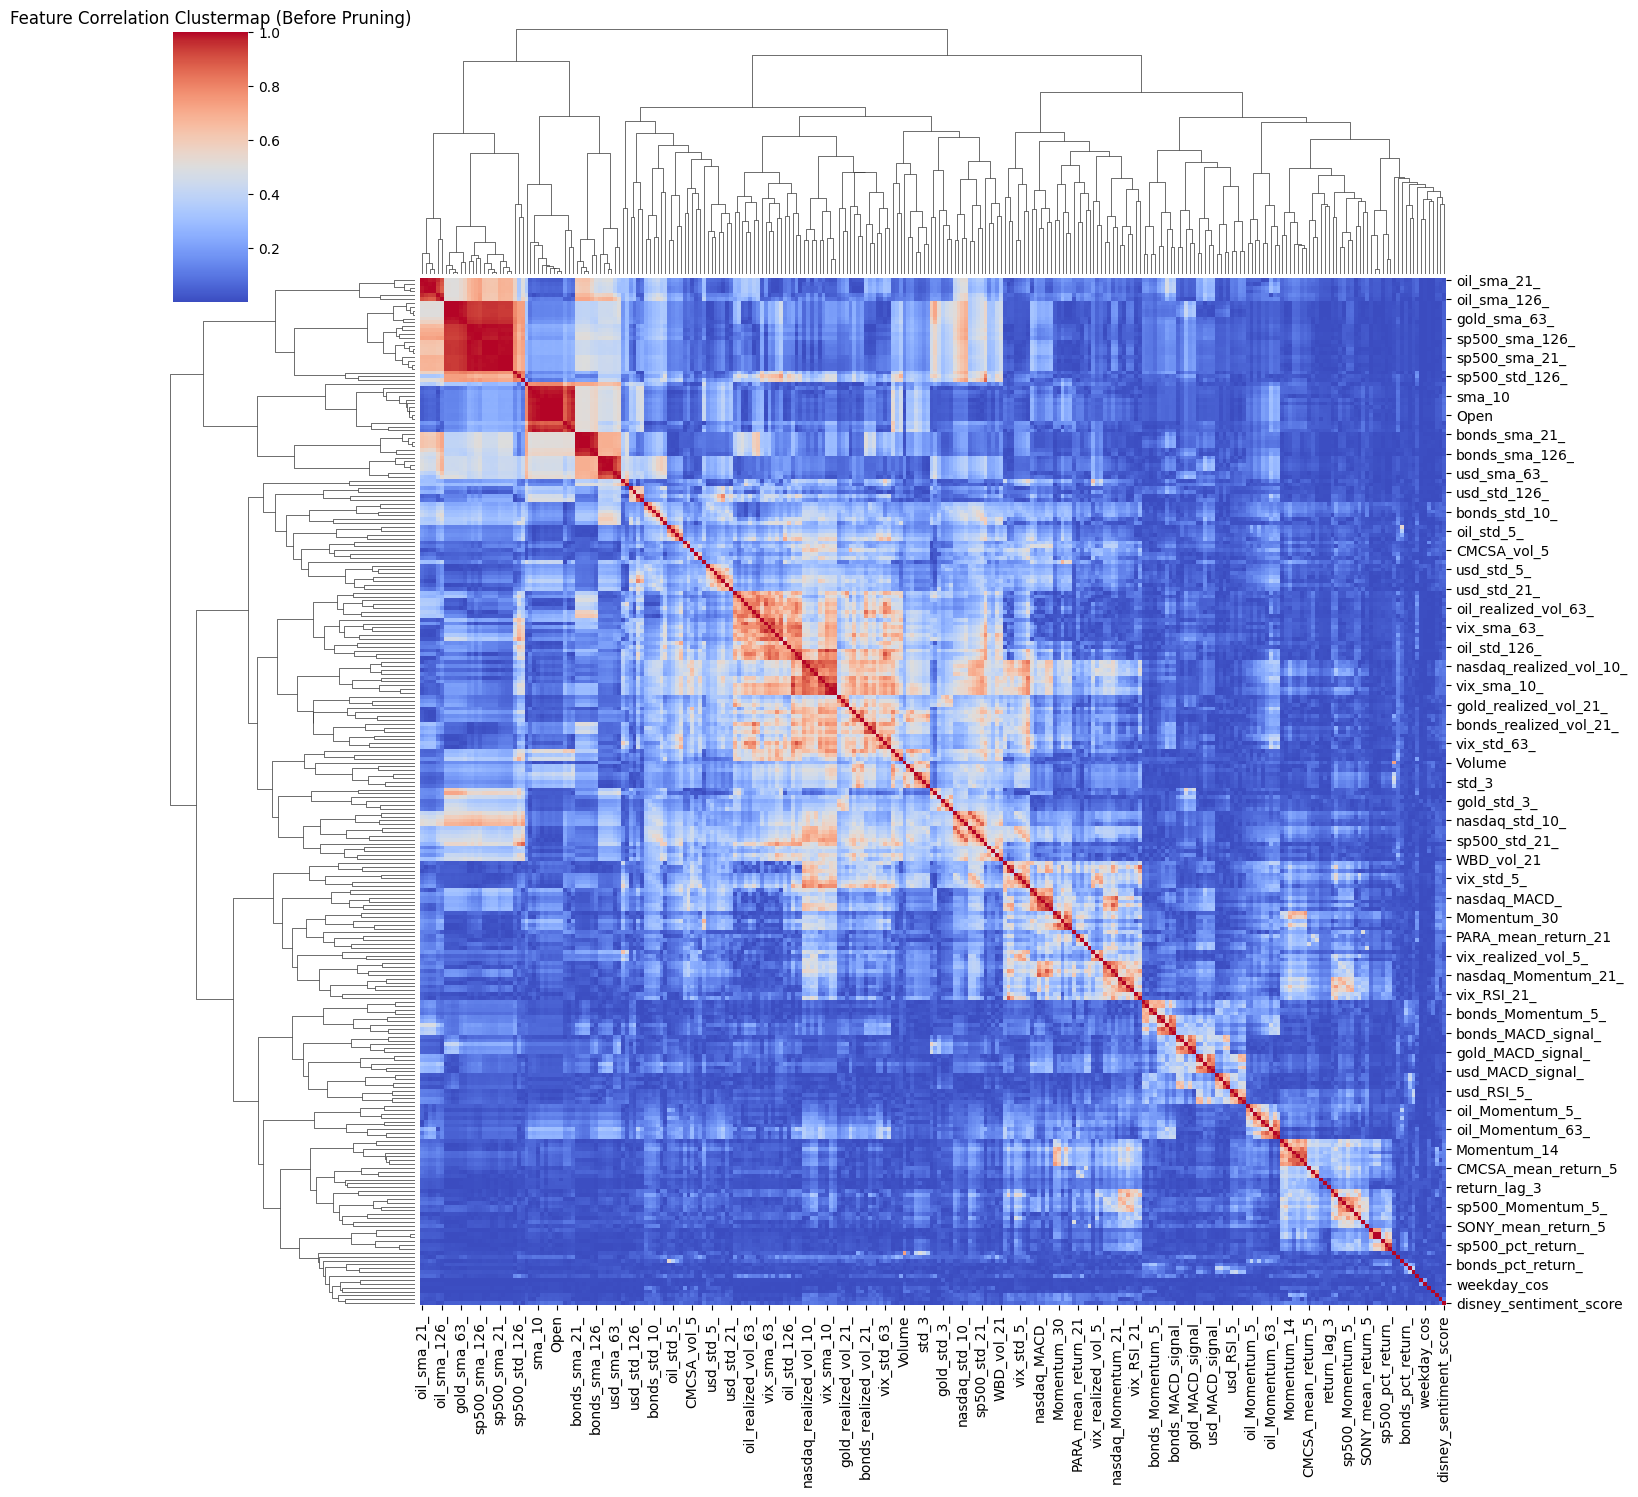

Reduced from 266 to 185 components


In [64]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlation matrix
corr_matrix = df_disney_final.corr().abs()

# Select upper triangle (since matrix is symmetric)
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Drop features with correlation > threshold
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
df_pruned = df_disney_final.drop(columns=to_drop)
sns.clustermap(corr_matrix, cmap='coolwarm', figsize=(15, 15))
plt.title("Feature Correlation Clustermap (Before Pruning)")
plt.show()


print(f"Reduced from {df_disney_final.shape[1]} to {df_pruned.shape[1]} components")

In [83]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X_scaled = StandardScaler().fit_transform(df_disney_final.dropna())

pca = PCA(n_components=0.95)  # keep enough components to explain 95% variance
X_pca = pca.fit_transform(X_scaled)

print(f"Reduced from {df_disney_final.shape[1]} to {X_pca.shape[1]} components")


Reduced from 266 to 82 components


In [17]:
from sklearn.decomposition import KernelPCA
from sklearn.preprocessing import StandardScaler

# Step 1: Standardize input features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_disney_final)  # df: your DataFrame (no NaNs)

# Step 2: Apply KernelPCA
kpca = KernelPCA(n_components=50, kernel='rbf', gamma=0.01, fit_inverse_transform=False, n_jobs=-1)
X_kpca = kpca.fit_transform(X_scaled)

print(f"Reduced from {df_disney_final.shape[1]} to {X_kpca.shape[1]} components")


Reduced from 266 to 50 components


In [ ]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def create_lgbm_dataset(df, window=126, horizon=21, target_col="pct_return"):
    df = df.copy().dropna().reset_index(drop=True)
    feature_names = df.columns.tolist()
    X, Y, col_names = [], [], []

    for i in range(len(df) - window - horizon):
        window_slice = df.iloc[i:i+window]
        flat = window_slice.values.flatten()
        X.append(flat)
        Y.append(df.iloc[i+window + horizon - 1][target_col])

    # Create synthetic column names
    col_names = [
        f"{feat}_t-{window-j-1}"
        for j in range(window)
        for feat in feature_names
    ]

    return np.array(X), np.array(Y), col_names

X_lightgbm, Y_lightgbm, col_names = create_lgbm_dataset(df_disney_final)

X_train, X_val, y_train, y_val = train_test_split(X_lightgbm, Y_lightgbm, test_size=0.2, shuffle=False)

train_data = lgb.Dataset(X_train, label=y_train, feature_name=col_names)
val_data = lgb.Dataset(X_val, label=y_val, feature_name=col_names)

# Parameters
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.01,
    'num_leaves': 31,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbosity': -1,
    'seed': 42
}

# Train
model = lgb.train(
    params,
    train_data,
    valid_sets=[train_data, val_data],
    num_boost_round=1000,
)

In [ ]:
(
    pd.DataFrame({
        'feature': model.feature_name(),
        'importance': model.feature_importance(),
    })
    .sort_values('importance', ascending=False)
) 


,feature,importance
11477,stoch_D_t-82,24
21843,OBV_t-43,22
32290,nasdaq_pct_return__t-4,22
30078,price_change_t-12,22
30876,price_change_t-9,21
...,...,...
11769,vix_RSI_21__t-81,0
11768,vix_RSI_10__t-81,0
11767,vix_RSI_5__t-81,0
11766,vix_std_126__t-81,0


## Transformer training

In [3]:
df_disney_final = pd.read_csv("df_disney_final.csv", index_col = 0)

In [17]:
class Transformer(nn.Module):
    def __init__(self, input_dim, embedding_dimensions=256, attention_heads=4, num_layers=2, dim_feedforward=256, output_dims=2, dropout=0.1):
        super().__init__()
        self.embedding = nn.Sequential(
            nn.Linear(input_dim, embedding_dimensions),
            nn.LayerNorm(embedding_dimensions),
            nn.Dropout(dropout)  # Dropout after embedding
        )
        self.pos_encoding = nn.Parameter(0.1 * torch.randn(1, 126, embedding_dimensions))
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embedding_dimensions,
            nhead=attention_heads,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            activation="relu"
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.head = nn.Linear(embedding_dimensions, 1)


    def forward(self, x):
        x = self.embedding(x) + self.pos_encoding[:, :x.size(1)]
        x = x.permute(1, 0, 2)  # [T, B, E]
        x = self.transformer(x)
        out = x[-1]  # use the last time step
        return self.head(out)


In [9]:
def create_multistep_sequences(df, window=126,target_col="pct_return"):
    df = df.dropna().reset_index(drop=True)
    X, Y = [], []
    for i in range(len(df) - window - 1):
        X.append(df.iloc[i:i+window].values)
        future_returns = 1 if df.iloc[i+window+1][target_col] > 0 else 0 # 1 -> pct_returns > 0, 0 is pct_returns =< 0
        Y.append(future_returns)
    return np.array(X), np.array(Y)

In [10]:
#df_pca = pd.DataFrame(df_disney_final['pct_return'].reset_index(drop=True)).join(pd.DataFrame(X_pca))
#X, Y = create_multistep_sequences(df_pca, horizon=5, target_col="pct_return")
X, Y = create_multistep_sequences(df_disney_final, target_col="pct_return")

In [14]:
class StockDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Train-test split
split_idx = int(len(X) * 0.9)
X_train, X_val, y_train, y_val = X[:split_idx], X[split_idx:], Y[:split_idx], Y[split_idx:]

# Normalize
# X_train = (X_train - X_train.mean(axis=0)) / (X_train.std(axis=0) + 1e-6) 
# X_val = (X_val - X_train.mean(axis=0)) / (X_train.std(axis=0) + 1e-6)
# y_train = (y_train - y_train.mean()) / (y_train.std() + 1e-6)
# y_val   = (y_val - y_train.mean()) / (y_train.std() + 1e-6)

train_ds = StockDataset(X_train, y_train)
val_ds   = StockDataset(X_val, y_val)

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=16)

In [15]:
from torch.optim.lr_scheduler import CosineAnnealingLR

In [16]:
import torch.nn.functional as F
def combined_mse_directional_loss(pred, target, alpha=0.8):
    """
    pred, target: tensors of shape [B, H] or [B] for single-step
    """
    # Flatten if needed
    if pred.ndim == 2:
        pred = pred.view(-1)
        target = target.view(-1)

    # MSE for magnitude
    mse_loss = F.mse_loss(pred, target)

    # Directional loss (sign-based)
    pred_sign = torch.sigmoid(pred)  # smoothed sign probability
    true_sign = (target > 0).float()
    direction_loss = F.binary_cross_entropy(pred_sign, true_sign)

    return alpha * mse_loss + (1 - alpha) * direction_loss

def trend_only_loss(pred, target, temperature=0.5):
    pred = pred.view(-1)
    target = target.view(-1)

    # Soft sign with sigmoid (differentiable)
    pred_sign_prob = torch.sigmoid(pred / temperature)
    true_sign = (target > 0).float()

    return F.binary_cross_entropy(pred_sign_prob, true_sign)



In [62]:
model = Transformer(input_dim=X.shape[2], dropout=0.3).to(device)
EPOCHS = 20
optimizer = optim.Adam(model.parameters(), lr=5e-5)
#criterion = nn.MSELoss()
criterion = nn.BCEWithLogitsLoss()
scheduler = CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=5e-7)

def train_one_epoch():
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        pred = model(xb).squeeze(-1)
        loss = criterion(pred, yb)
        #loss = combined_mse_directional_loss(pred, yb, 0.2)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

def evaluate():
    model.eval()
    total_loss = 0
    with torch.inference_mode():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb).squeeze(-1)
            loss = criterion(pred, yb)
            #loss = combined_mse_directional_loss(pred, yb)
            total_loss += loss.item()
    return total_loss / len(val_loader)


/home/kristijonas/.pyenv/versions/stock_transformers_env/lib/python3.11/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [63]:
val_loss = evaluate()
print(f"Before start Val Loss: {val_loss:.6f}")
for epoch in range(EPOCHS):
    train_loss = train_one_epoch()
    val_loss = evaluate()
    #scheduler.step()  # Update the learning rate
    print(f"Epoch {epoch + 1:2d} | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}")

Before start Val Loss: 0.808677
Epoch  1 | Train Loss: 0.719566 | Val Loss: 0.696997
Epoch  2 | Train Loss: 0.708923 | Val Loss: 0.694063
Epoch  3 | Train Loss: 0.706748 | Val Loss: 0.693017
Epoch  4 | Train Loss: 0.712188 | Val Loss: 0.700314
Epoch  5 | Train Loss: 0.705619 | Val Loss: 0.692349
Epoch  6 | Train Loss: 0.702922 | Val Loss: 0.703773
Epoch  7 | Train Loss: 0.706892 | Val Loss: 0.698422
Epoch  8 | Train Loss: 0.698891 | Val Loss: 0.695414
Epoch  9 | Train Loss: 0.705751 | Val Loss: 0.692977
Epoch 10 | Train Loss: 0.703082 | Val Loss: 0.693061
Epoch 11 | Train Loss: 0.704744 | Val Loss: 0.692666
Epoch 12 | Train Loss: 0.704516 | Val Loss: 0.694084
Epoch 13 | Train Loss: 0.702511 | Val Loss: 0.701107
Epoch 14 | Train Loss: 0.701109 | Val Loss: 0.707972
Epoch 15 | Train Loss: 0.699841 | Val Loss: 0.692608
Epoch 16 | Train Loss: 0.698405 | Val Loss: 0.695083
Epoch 17 | Train Loss: 0.699822 | Val Loss: 0.702485
Epoch 18 | Train Loss: 0.701556 | Val Loss: 0.695917
Epoch 19 | Tra

In [22]:
torch.save(model.state_dict(), "stock_transformer.pth")

## Testing

In [44]:
df_disney_final = pd.read_csv('df_disney_final.csv', index_col = 0)

In [45]:
model = Transformer(input_dim=X.shape[2]).to(device)
model.load_state_dict(torch.load("stock_transformer.pth", map_location=device))

/home/kristijonas/.pyenv/versions/stock_transformers_env/lib/python3.11/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


<All keys matched successfully>

In [64]:
model.eval()
all_preds = []
all_targets = []

with torch.inference_mode():
    for xb, yb in val_loader:
        xb = xb.to(device)
        yb = yb.to(device)

        preds = model(xb).squeeze(-1)  # shape: (batch_size, horizon)
        all_preds.append(preds.cpu().numpy())
        all_targets.append(yb.cpu().numpy())

# all_preds = np.vstack(all_preds)     # shape: (num_samples, horizon)
# all_targets = np.vstack(all_targets) # same shape
all_preds = np.concatenate(all_preds)
all_targets = np.concatenate(all_targets)

# example = 151  # index of sample to inspect
# plt.plot(all_targets[example], label='Actual')
# plt.plot(all_preds[example], label='Predicted')
# plt.legend()
# plt.title("Multi-step Forecast")
# plt.xlabel("Timestep (Day)")
# plt.ylabel("Pct Return")
# plt.grid(True)
# plt.show()

In [ ]:
# y_pred = all_preds.flatten()
# y_true = all_targets.flatten()

# mse = mean_squared_error(y_true, y_pred)
# mae = mean_absolute_error(y_true, y_pred)
# r2 = r2_score(y_true, y_pred)
# accuracy = np.mean(np.sign(y_pred) == np.sign(y_true))

# print(f"MSE: {mse:.6f}")
# print(f"MAE: {mae:.6f}")
# print(f"R²:  {r2:.6f}")
# print(f"Directional Accuracy: {accuracy:.2%}")

MSE: 0.042564
MAE: 0.180899
R²:  -157.313141
Directional Accuracy: 51.24%


In [81]:
y_pred = all_preds.flatten()
y_pred = np.round(1 / (1 + np.exp(-y_pred)), decimals=0)
y_true = all_targets.flatten()

accuracy = np.mean(y_pred == y_true)
print(f"Directional Accuracy: {accuracy:.2%}")

Directional Accuracy: 48.90%


In [57]:
y_true.mean()

np.float32(0.5110132)

In [153]:
y_pred = np.zeros(2260)
y_true = all_targets.flatten()

mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
accuracy = np.mean(np.sign(y_pred) == np.sign(y_true))

print(f"MSE: {mse:.6f}")
print(f"MAE: {mae:.6f}")
print(f"R²:  {r2:.6f}")
print(f"Directional Accuracy: {accuracy:.2%}")

MSE: 0.000269
MAE: 0.011143
R²:  -0.000932
Directional Accuracy: 0.66%


## Logistic Regression

In [86]:
def create_multistep_sequences(df, target_col="pct_return"):
    df = df.dropna().reset_index(drop=True)
    X, Y = [], []
    for i in range(len(df) - 1):
        X.append(df.iloc[i,:].values)
        future_returns = 1 if df.iloc[i+1][target_col] > 0 else 0 # 1 -> pct_returns > 0, 0 is pct_returns =< 0
        Y.append(future_returns)
    return np.array(X), np.array(Y)

X, Y = create_multistep_sequences(df_disney_final)

In [89]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

# X: features of shape [n_samples, n_features]
# y: percentage returns of shape [n_samples]

X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

# Step 3: Fit logistic regression
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Step 4: Evaluate
y_pred = model.predict(X_val)

print("Accuracy:", accuracy_score(y_val, y_pred))
print("Precision:", precision_score(y_val, y_pred))
print("Recall:", recall_score(y_val, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred))


Accuracy: 0.48535564853556484
Precision: 0.46226415094339623
Recall: 0.6621621621621622
Confusion Matrix:
 [[ 85 171]
 [ 75 147]]


/home/kristijonas/.pyenv/versions/stock_transformers_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [90]:
y_pred

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1,
       1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0,
       1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1,
       0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0,

## LightGBM

In [117]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

df_disney_final['tomorrow_pct_return'] = df_disney_final.loc[:,'pct_return'].shift(1)
df_disney_final = df_disney_final.loc[(df_disney_final['disney_sentiment_score'] > 0.5) | (df_disney_final['disney_sentiment_score'] < -0.5), :].drop(columns='disney_news').dropna(axis=0)
X_lightgbm, Y_lightgbm = df_disney_final.drop(columns='tomorrow_pct_return'), df_disney_final['tomorrow_pct_return']
X_train, X_val, y_train, y_val = train_test_split(X_lightgbm, Y_lightgbm, test_size=0.2, shuffle=False)

# LightGBM dataset format
train_data = lgb.Dataset(X_train, label=y_train)
val_data = lgb.Dataset(X_val, label=y_val)

# Parameters
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.01,
    'num_leaves': 31,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbosity': -1,
    'seed': 42
}

# Train
model = lgb.train(
    params,
    train_data,
    valid_sets=[train_data, val_data],
    num_boost_round=1000,
)

# Predict
y_pred = model.predict(X_val)

# Evaluation
mse = mean_squared_error(y_val, y_pred)
mae = mean_absolute_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)
directional_acc = (np.sign(y_pred) == np.sign(y_val)).mean()

print(f"MSE: {mse:.6f}")
print(f"MAE: {mae:.6f}")
print(f"R²: {r2:.6f}")
print(f"Directional Accuracy: {directional_acc * 100:.2f}%")

MSE: 0.000338
MAE: 0.013824
R²: 0.023569
Directional Accuracy: 58.18%


In [ ]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def create_lgbm_dataset(df, target_col="pct_return"):
    df = df.copy().dropna().reset_index(drop=True)
    X, Y = [], []
    for i in range(len(df)):
        window_slice = df.iloc[i,:].values.flatten()  # shape: (window * num_features,)
        X.append(window_slice)
        Y.append(df.iloc[i+1][target_col])  # next-day or t+h return
    return np.array(X), np.array(Y)

X_lightgbm, Y_lightgbm = create_lgbm_dataset(df_disney_final)
# Assume X: your features, y: target (e.g. next-day % return)
X_train, X_val, y_train, y_val = train_test_split(X_lightgbm, Y_lightgbm, test_size=0.2, shuffle=False)

# LightGBM dataset format
train_data = lgb.Dataset(X_train, label=y_train)
val_data = lgb.Dataset(X_val, label=y_val)

# Parameters
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.01,
    'num_leaves': 31,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbosity': -1,
    'seed': 42
}

# Train
model = lgb.train(
    params,
    train_data,
    valid_sets=[train_data, val_data],
    num_boost_round=1000,
)

# Predict
y_pred = model.predict(X_val)

# Evaluation
mse = mean_squared_error(y_val, y_pred)
mae = mean_absolute_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)
directional_acc = (np.sign(y_pred) == np.sign(y_val)).mean()

print(f"MSE: {mse:.6f}")
print(f"MAE: {mae:.6f}")
print(f"R²: {r2:.6f}")
print(f"Directional Accuracy: {directional_acc * 100:.2f}%")


MSE: 0.000376
MAE: 0.012535
R²: -0.089429
Directional Accuracy: 40.00%


In [30]:
from huggingface_hub import hf_hub_download
import torch
from transformers import AutoformerModel

file = hf_hub_download(
    repo_id="hf-internal-testing/tourism-monthly-batch", filename="train-batch.pt", repo_type="dataset"
)
batch = torch.load(file)

In [ ]:
from transformers import AutoformerConfig, AutoformerModel

# Initializing a default Autoformer configuration
configuration = AutoformerConfig()

# Randomly initializing a model (with random weights) from the configuration
model = AutoformerModel(configuration)

# Accessing the model configuration
configuration = model.config

# during training, one provides both past and future values
# as well as possible additional features
outputs = model(
    past_values=batch["past_values"],
    past_time_features=batch["past_time_features"],
    past_observed_mask=batch["past_observed_mask"],
    static_categorical_features=batch["static_categorical_features"],
    future_values=batch["future_values"],
    future_time_features=batch["future_time_features"],
)

loss = outputs.loss
loss.backward()

# during inference, one only provides past values
# as well as possible additional features
# the model autoregressively generates future values
outputs = model.generate(
    past_values=batch["past_values"],
    past_time_features=batch["past_time_features"],
    past_observed_mask=batch["past_observed_mask"],
    static_categorical_features=batch["static_categorical_features"],
    future_time_features=batch["future_time_features"],
)

mean_prediction = outputs.sequences.mean(dim=1)